# Using a predefined random seed and saving the outputs at each step. This is for reproducibility. Simulations with noise

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import dataclasses as dt

In [53]:
import os
import shutil
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline28IDB.optimization.common as opt_common
import aps.ai.autoalignment.beamline28IDB.optimization.configs as configs
import aps.ai.autoalignment.beamline28IDB.optimization.movers as movers
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
from aps.ai.autoalignment.beamline28IDB.facade.focusing_optics_factory import (
    ExecutionMode,
    focusing_optics_factory_method,
)
from aps.ai.autoalignment.beamline28IDB.optimization.optuna_botorch import OptunaOptimizer
from aps.ai.autoalignment.beamline28IDB.simulation.facade.focusing_optics_interface import (
    Layout,
    get_default_input_features,
)
from aps.ai.autoalignment.common.simulation.facade.parameters import Implementors
from aps.ai.autoalignment.common.util import clean_up
from aps.ai.autoalignment.common.util.common import AspectRatio, ColorMap, PlotMode
from aps.ai.autoalignment.common.util.shadow.common import (
    EmptyBeamException,
    HybridFailureException,
    PreProcessorFiles,
    load_shadow_beam,
)
from aps.ai.autoalignment.common.util.wrappers import load_beam

import aps.ai.autoalignment.beamline28IDB.optimization.analysis_utils as analysis
from datetime import datetime
import joblib
import matplotlib as mpl
import cmasher as cm
import colorcet as cc

from epics import ca
ca.finalize_libca()

%matplotlib inline

In [72]:
mpl.rcParams.update({'font.size': 16, 'text.usetex':True})

In [3]:
DEFAULT_RANDOM_SEED = 10

In [4]:
class OptimizationParameters:
    def __init__(self):
        self.move_motors_ranges = configs.DEFAULT_MOVEMENT_RANGES

        self.params = {
            "sum_intensity_soft_constraint": 7.5e3,
            "sum_intensity_hard_constraint": 6e3,
            #            "centroid_sigma_loss_threshold_dependency": CentroidSigmaLossThresholdDependency.FULLY_DYNAMIC,
            #            "centroid_sigma_loss_hard_thresholds": [0.01, 0.03],
            "loss_parameters": ["fwhm", "peak_distance", "negative_log_peak_intensity"],
            "multi_objective_optimization": True,
            "n_pitch_trans_motor_trials": 50,
            "n_all_motor_trials": 100,
            "moo_thresholds": {"fwhm":0.02}
        }

In [5]:
def setup_work_dir():
    root_dir = Path(aps.__path__[0]).parents[0]
    work_dir = root_dir / "work_directory/28-ID"
    os.chdir(work_dir)

In [6]:
def print_beam_attributes(loss_parameters, hist, dw, title):
    loss_dw_functions = {
        "peak_distance": opt_common._get_peak_distance_from_dw,
        "centroid": opt_common._get_centroid_distance_from_dw,
        "sigma": opt_common._get_sigma_from_dw,
        "fwhm": opt_common._get_fwhm_from_dw,
    }
    loss_hist_functions = {
        "log_weighted_sum_intensity": lambda hist: np.log(opt_common._get_weighted_sum_intensity_from_hist(hist, 2))
    }

    attribs = {}
    for ltype in loss_parameters:
        if ltype in loss_dw_functions:
            loss = loss_dw_functions[ltype](dw)
        if ltype in loss_hist_functions:
            loss = loss_hist_functions[ltype](hist)
        attribs[ltype] = loss
        print(f"{title} system {ltype}: {loss:4.3e}")
    return attribs

In experiments, the perturbed max is about 400 times higher than the noise level. This seems to hold in sim with noise level 0.5

In [7]:
detector_x = 2160 * 0.65 * 1e-3
detector_y = 2560 * 0.65 * 1e-3
cp = opt_common.CalculationParameters(
    xrange= [-detector_x / 2, detector_x / 2],
    yrange = [-detector_y / 2, detector_y / 2],
    nbins_h = 1024,
    nbins_v = 1024,
    use_denoised = False,
    random_seed = DEFAULT_RANDOM_SEED,
    add_noise = True,
    calculate_over_noise= False,
    implementor=Implementors.SHADOW,
    percentage_fluctuation=50,
    noise=0.5,
    save_images=True,
    every_n_images=1
   )

xrange_plot = [-0.3, 0.3]
yrange_plot = [-0.3, 0.3]

ppm = opt_common.PlotParameters(xrange=xrange_plot, yrange=yrange_plot, nbins_h = cp.nbins_h // 2, nbins_v = cp.nbins_v // 2)


In [8]:
setup_work_dir()
clean_up()

print(cp)

CalculationParameters(execution_mode=0, implementor=0, xrange=[-0.7020000000000001, 0.7020000000000001], yrange=[-0.8320000000000001, 0.8320000000000001], nbins_h=1024, nbins_v=1024, do_gaussian_fit=False, use_denoised=False, from_raw_image=True, random_seed=10, add_noise=True, noise=0.5, percentage_fluctuation=50, calculate_over_noise=False, noise_threshold=1.5, reference_h=0.0, reference_v=0.0, save_images=True, every_n_images=1, rng=Generator(PCG64) at 0x7FC278D1DD60)


In [9]:
ppm

PlotParameters(implementor=0, title='X,Z', xrange=[-0.3, 0.3], yrange=[-0.3, 0.3], nbins_h=512, nbins_v=512, plot_mode=0, aspect_ratio=0, color_map=<matplotlib.colors.ListedColormap object at 0x7fc29830a9d0>)

In [10]:
opt_params = OptimizationParameters()

print("Motors and movement ranges")
print(opt_params.move_motors_ranges)

print("Optimization parameters")
print(opt_params.params)

Motors and movement ranges
{'hb_1': [-25, 25], 'hb_2': [-25, 25], 'hb_pitch': [-0.002, 0.002], 'hb_trans': [-0.03, 0.03], 'vb_bender': [-20.0, 20.0], 'vb_pitch': [-0.002, 0.002], 'vb_trans': [-0.03, 0.03]}
Optimization parameters
{'sum_intensity_soft_constraint': 7500.0, 'sum_intensity_hard_constraint': 6000.0, 'loss_parameters': ['fwhm', 'peak_distance', 'negative_log_peak_intensity'], 'multi_objective_optimization': True, 'n_pitch_trans_motor_trials': 50, 'n_all_motor_trials': 100, 'moo_thresholds': {'fwhm': 0.02}}


In [11]:
input_beam_path = "primary_optics_system_beam.dat"

clean_up()

# Initializing the focused beam from simulation
input_features = get_default_input_features(layout=Layout.AUTO_FOCUSING)
input_beam = load_shadow_beam(input_beam_path)
focusing_system = focusing_optics_factory_method(
    execution_mode=ExecutionMode.SIMULATION,
    implementor=Implementors.SHADOW,
    bender=True,
)

focusing_system.initialize(
    input_photon_beam=input_beam,
    rewrite_preprocessor_files=PreProcessorFiles.NO,
    layout=Layout.AUTO_FOCUSING,
    input_features=input_features,
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


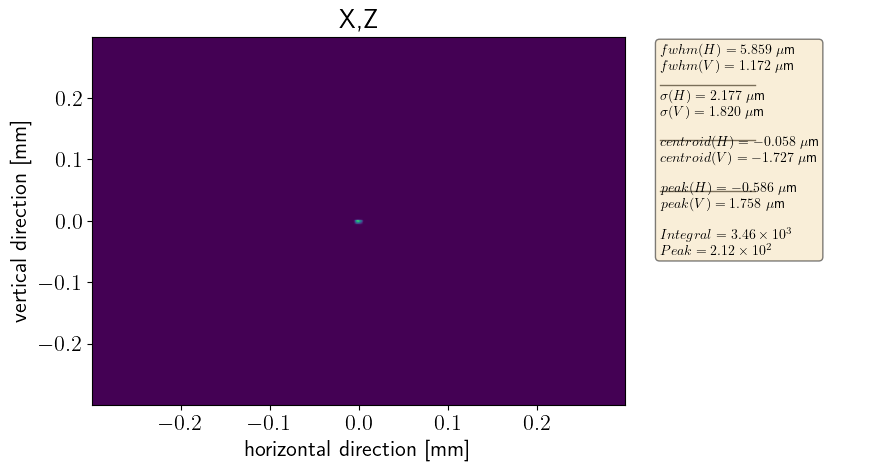

In [12]:
beam, hist, dw = opt_common.get_beam_hist_dw(cp=cp,focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(photon_beam=beam, ppm=ppm)

In [13]:
m2 = cm.get_sub_cmap(cm.sunburst_r, 0, 0.5)

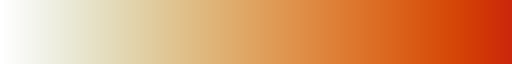

In [14]:
m2

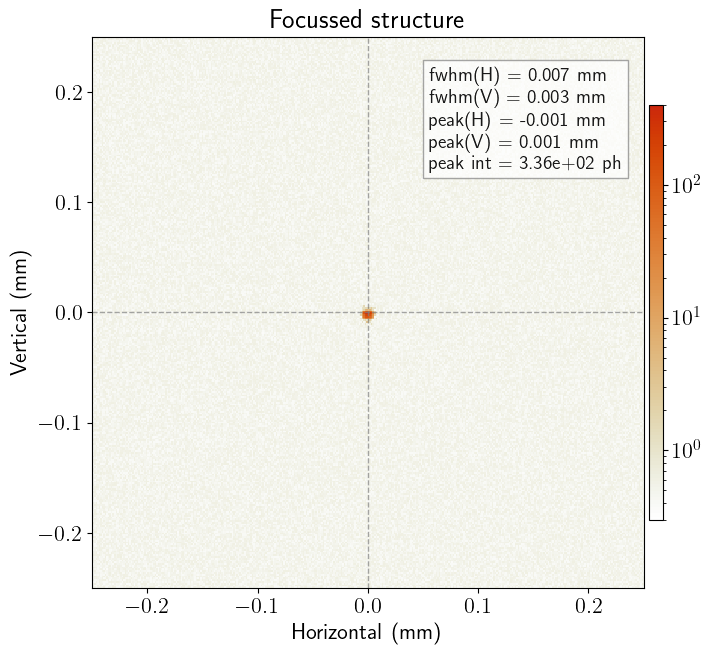

In [15]:
dwd = dw._DictionaryWrapper__dictionary
plt.figure(figsize=[7,7], constrained_layout=True)
plt.pcolormesh(hist.hh, hist.vv, hist.data_2D.T, cmap=m2, norm=mpl.colors.LogNorm(0.3, 4e2))
plt.xlim(-0.25,0.25)
plt.ylim(-0.25,0.25)
plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.xlabel('Horizontal (mm)')
plt.ylabel('Vertical (mm)')
plt.title("Focussed structure")
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

ax = plt.gca()
ax.set_aspect('equal')

text = (f"{'fwhm(H)':<6} = {dwd['h_fwhm']: 4.3f} mm\n"
             f"{'fwhm(V)':<9} = {dwd['v_fwhm']: 4.3f} mm\n"
             f"{'peak(H)':<9} = {dwd['h_peak']: 4.3f} mm\n"
             f"{'peak(V)':<9} = {dwd['v_peak']: 4.3f} mm\n"
             f"{'peak int':<9} = {dwd['peak_intensity']: 3.2e} ph")
ax.text(0.055, 0.13, text, color='black', alpha=0.9, fontsize=14,
        bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7))
plt.show()

In [16]:
hist.data_2D[:10, :10].mean(), hist.data_2D.sum()

(0.49308935960534506, 527668.5127037812)

In [17]:
hist.data_2D.max() / hist.data_2D[:10, :10].mean()

681.5356017104089

In [18]:
attribs_focus = print_beam_attributes(opt_params.params['loss_parameters'], hist, dw, "Focused beam")

Focused beam system fwhm: 7.587e-03
Focused beam system peak_distance: 1.063e-03
Focused beam system negative_log_peak_intensity: 1.063e-03


In [19]:
mots = list(opt_params.move_motors_ranges.keys())
initial_absolute_positions = {k: movers.get_absolute_positions(focusing_system, k)[0] for k in mots}
print("Focused absolute position are", initial_absolute_positions)



Focused absolute position are {'hb_1': -168.0, 'hb_2': -161.0, 'hb_pitch': 0.17188733853924987, 'hb_trans': 0.0, 'vb_bender': 419.0, 'vb_pitch': 0.17188733853924987, 'vb_trans': 0.0}


In [20]:
# Adding random perturbation to the motor values
initial_movement, focusing_system, (beam_init, hist_init, dw_init) = opt_common.get_random_init(
    focusing_system=focusing_system,
    motor_types_and_ranges=opt_params.move_motors_ranges,
    intensity_sum_threshold=opt_params.params["sum_intensity_hard_constraint"],
    cp=cp,
    
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.
Random initialization is (ABSOLUTE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [-145.2, -175.6, 0.17058733853924987, -0.042, 419.5, 0.17042733853924988, 0.0113]
Random initialization is (RELATIVE) ['hb_1', 'hb_2', 'hb_pitch', 'hb_trans', 'vb_bender', 'vb_pitch', 'vb_trans'] [22.800085481448768, -14.615909496042656, 0.001313779541098123, -0.021043072615078783, 0.5121846574625941, -0.0014563215839179734, 0.011342188786867866]


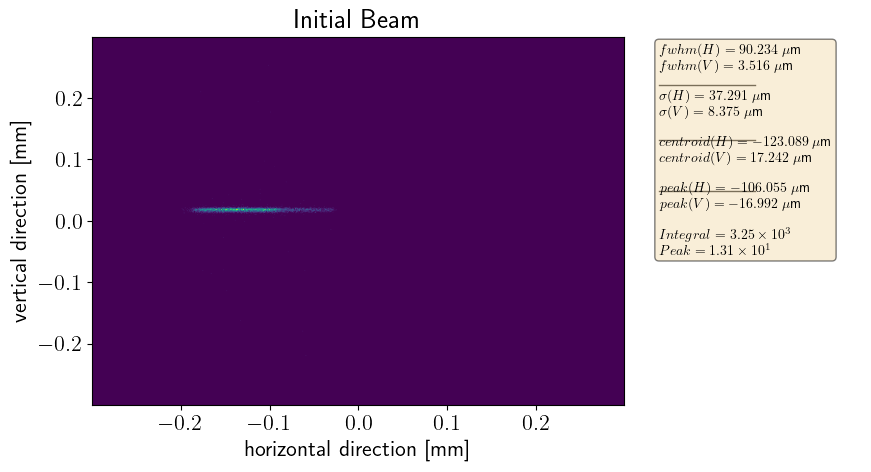

Perturbed beam system fwhm: 1.403e+00
Perturbed beam system peak_distance: 1.388e-01
Perturbed beam system negative_log_peak_intensity: 1.388e-01


In [22]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert, ppm=ppm,
    title="Initial Beam",
)
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

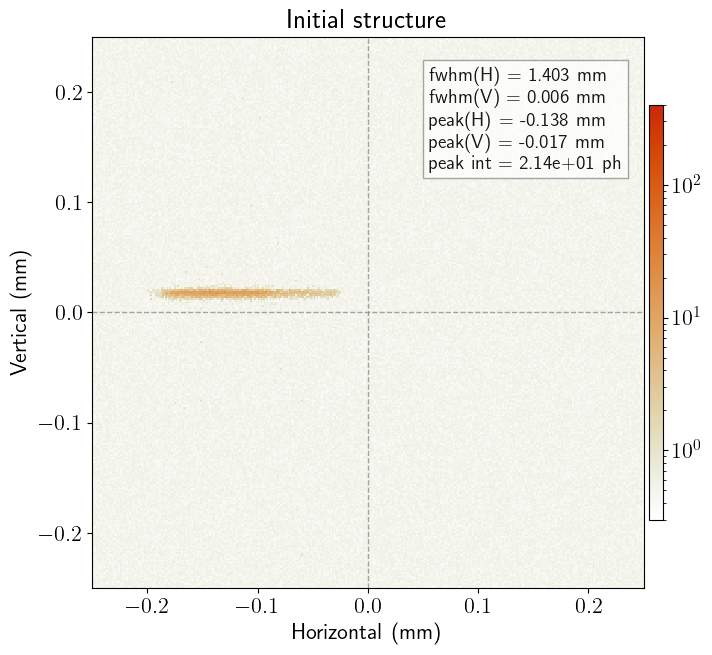

In [23]:
dwd = dw_pert._DictionaryWrapper__dictionary
plt.figure(figsize=[7,7], constrained_layout=True)
plt.pcolormesh(hist_pert.hh, hist_pert.vv, hist_pert.data_2D.T, cmap=m2, norm=mpl.colors.LogNorm(0.3, 4e2))
plt.xlim(-0.25,0.25)
plt.ylim(-0.25,0.25)
plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.xlabel('Horizontal (mm)')
plt.ylabel('Vertical (mm)')
plt.title("Initial structure")
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

ax = plt.gca()
ax.set_aspect('equal')

text = (f"{'fwhm(H)':<6} = {dwd['h_fwhm']: 4.3f} mm\n"
             f"{'fwhm(V)':<9} = {dwd['v_fwhm']: 4.3f} mm\n"
             f"{'peak(H)':<9} = {dwd['h_peak']: 4.3f} mm\n"
             f"{'peak(V)':<9} = {dwd['v_peak']: 4.3f} mm\n"
             f"{'peak int':<9} = {dwd['peak_intensity']: 3.2e} ph")
ax.text(0.055, 0.13, text, color='black', alpha=0.9, fontsize=14,
        bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7))
plt.show()

In [24]:
perturbed_positions = initial_movement + np.array(list(initial_absolute_positions.values()))

#### Calculating without removing noise

In [25]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement='absolute')

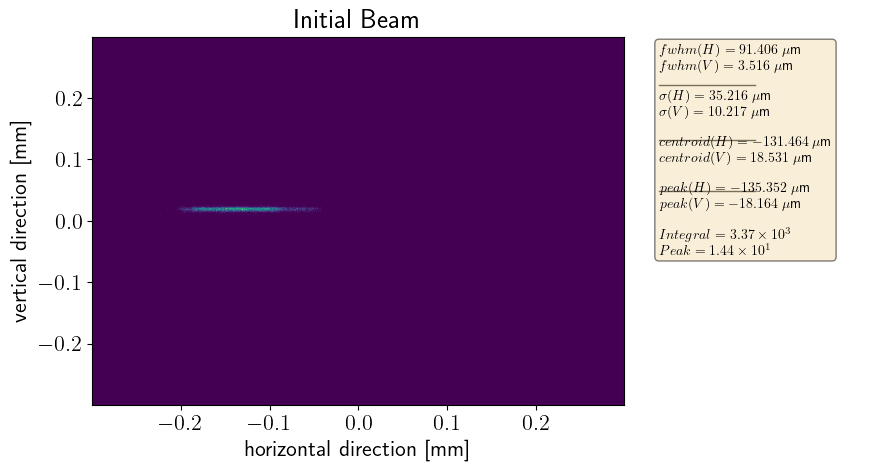

In [26]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert,
    title="Initial Beam",
    ppm=ppm
)

In [27]:
hist_pert.data_2D.max()

19.762919485829357

In [28]:
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

Perturbed beam system fwhm: 1.403e+00
Perturbed beam system peak_distance: 1.499e-01
Perturbed beam system negative_log_peak_intensity: 1.499e-01


In [29]:
opt_params = OptimizationParameters()

In [30]:
# Now the optimization
opt_trial = OptunaOptimizer(calculation_parameters=cp,
    focusing_system=focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    )

In [31]:
moo_thresholds = opt_params.params["moo_thresholds"]
for ltype in opt_params.params["loss_parameters"]:
    if ltype not in moo_thresholds:
        moo_thresholds[ltype] = opt_trial.get_beam_property_function_for_loss(ltype)()

In [32]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=moo_thresholds
)

[I 2023-06-02 15:30:29,288] A new study created in memory with name: no-name-212d2a68-c4c1-4c52-9917-7bcd7a2d3c14


In [33]:
opt_trial.trials(100)#, trial_motor_types=['hb_pitch', 'hb_trans', 'vb_pitch', 'vb_trans'])

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.03, 0.029900000000000003] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.03, 0.0299].
  warnings.warn(
[I 2023-06-02 15:30:38,027] Trial 0 finished with values: [1.4026373780393353, 0.14993282737940575, -2.9649396726382085] and parameters: {'hb_1': 0.0, 'hb_2': 0.0, 'hb_pitch': 0.0, 'hb_trans': 0.0, 'vb_bender': 0.0, 'vb_pitch': 0.0, 'vb_trans': 0.0}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:30:46,993] Trial 1 finished with values: [1.4026524388718187, 0.21859199602842658, -2.2449602061118576] and parameters: {'hb_1': 14.0, 'hb_2': -24.0, 'hb_pitch': 0.0005, 'hb_trans': 0.014900000000000004, 'vb_bender': 0.0, 'vb_pitch': -0.00112, 'vb_trans': -0.0182}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:30:55,916] Trial 2 finished with values: [2.175053675032646, 0.5134573982529702, -0.6854881545019226] and parameters: {'hb_1': 13.0, 'hb_2': -17.0, 'hb_pitch': -0.0017000000000000001, 'hb_trans': 0.011100000000000006, 'vb_bender': 19.0, 'vb_pitch': -0.002, 'vb_trans': 0.0007000000000000027}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:31:04,719] Trial 3 finished with values: [2.175053675032646, 0.22630909050936088, -2.0555413268017397] and parameters: {'hb_1': 16.0, 'hb_2': 6.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': -0.012499999999999997, 'vb_bender': 17.0, 'vb_pitch': 0.00084, 'vb_trans': 0.0025000000000000022}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:31:13,542] Trial 4 finished with values: [1.4026439671734452, 0.1850571330437899, -3.5858197661606113] and parameters: {'hb_1': -18.0, 'hb_2': -6.0, 'hb_pitch': 0.0006000000000000003, 'hb_trans': -0.003499999999999996, 'vb_bender': -3.0, 'vb_pitch': 0.00046000000000000034, 'vb_trans': 0.0007000000000000027}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:31:22,379] Trial 5 finished with values: [2.175053675032646, 0.2731008366142094, -1.8414119051004638] and parameters: {'hb_1': 8.0, 'hb_2': 5.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.0012000000000000031, 'vb_bender': 17.0, 'vb_pitch': -0.00074, 'vb_trans': -0.024599999999999997}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:31:30,850] Trial 6 finished with values: [1.4026891489735211, 0.21531409439360294, -2.675123485479764] and parameters: {'hb_1': -10.0, 'hb_2': -20.0, 'hb_pitch': 0.0013, 'hb_trans': -0.0272, 'vb_bender': 5.0, 'vb_pitch': 0.00018000000000000004, 'vb_trans': 0.019100000000000006}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:31:40,164] Trial 7 finished with values: [1.4027644487397237, 0.07472902650574502, -3.8019863679549193] and parameters: {'hb_1': -15.0, 'hb_2': 18.0, 'hb_pitch': -0.0006000000000000001, 'hb_trans': 0.015200000000000005, 'vb_bender': -8.0, 'vb_pitch': 0.00152, 'vb_trans': -0.010499999999999999}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:31:48,779] Trial 8 finished with values: [2.175053675032646, 0.10543202892641905, -2.326225136212611] and parameters: {'hb_1': -17.0, 'hb_2': -5.0, 'hb_pitch': -0.0017000000000000001, 'hb_trans': 0.019200000000000002, 'vb_bender': -14.0, 'vb_pitch': -0.00047999999999999996, 'vb_trans': 0.026600000000000006}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:31:57,684] Trial 9 finished with values: [1.4026439671734452, 0.2954807570916114, -2.8441843893457928] and parameters: {'hb_1': 25.0, 'hb_2': -2.0, 'hb_pitch': 0.0013, 'hb_trans': -0.014999999999999998, 'vb_bender': 4.0, 'vb_pitch': 0.0016000000000000003, 'vb_trans': 0.0020000000000000018}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:32:14,682] Trial 10 finished with values: [2.175053675032646, 0.13844367911367256, -1.6236174943417043] and parameters: {'hb_1': 15.0, 'hb_2': -21.0, 'hb_pitch': 0.0007000000000000001, 'hb_trans': -0.0139, 'vb_bender': -16.0, 'vb_pitch': 0.00018000000000000004, 'vb_trans': 0.008200000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-pac

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:32:29,794] Trial 11 finished with values: [1.4026439671734452, 0.05130213951869417, -3.1145761474378078] and parameters: {'hb_1': 10.0, 'hb_2': 4.0, 'hb_pitch': -0.0012000000000000001, 'hb_trans': -0.006799999999999997, 'vb_bender': 1.0, 'vb_pitch': -0.00023999999999999998, 'vb_trans': 0.010100000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/pytho

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:32:47,706] Trial 12 finished with values: [1.4026373780393353, 0.09399169383990687, -4.064688923121214] and parameters: {'hb_1': 23.0, 'hb_2': 18.0, 'hb_pitch': -0.0006999999999999999, 'hb_trans': -0.022799999999999997, 'vb_bender': -5.0, 'vb_pitch': 0.0008000000000000004, 'vb_trans': -0.0264}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-pack

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:33:05,461] Trial 13 finished with values: [1.4026524388718187, 0.10601862993809827, -2.991420932041225] and parameters: {'hb_1': -4.0, 'hb_2': 5.0, 'hb_pitch': -0.00039999999999999996, 'hb_trans': -0.0020999999999999977, 'vb_bender': 2.0, 'vb_pitch': -0.0002999999999999999, 'vb_trans': -0.0298}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-pac

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:40:22,553] Trial 14 finished with values: [2.175053675032646, 0.1330102013282408, -2.202333130573938] and parameters: {'hb_1': 8.0, 'hb_2': 11.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': -0.0225, 'vb_bender': 17.0, 'vb_pitch': 0.0002800000000000003, 'vb_trans': 0.016}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distri

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:44:42,326] Trial 15 finished with values: [1.40270515051206, 0.2726387202865158, -3.294343907657269] and parameters: {'hb_1': 1.0, 'hb_2': 10.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': -0.018699999999999998, 'vb_bender': 3.0, 'vb_pitch': -0.00104, 'vb_trans': -0.027}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:45:01,927] Trial 16 finished with values: [1.40270515051206, 0.22334934395957848, -2.4940303014290355] and parameters: {'hb_1': 21.0, 'hb_2': -1.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': -0.010799999999999997, 'vb_bender': -6.0, 'vb_pitch': 0.0005400000000000001, 'vb_trans': -0.015099999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:45:19,758] Trial 17 finished with values: [2.175053675032646, 0.0732956630043039, -2.3295830191853377] and parameters: {'hb_1': -3.0, 'hb_2': 23.0, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.0265, 'vb_bender': 10.0, 'vb_pitch': 0.0004000000000000002, 'vb_trans': 0.015600000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packag

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:45:39,043] Trial 18 finished with values: [1.4026439671734452, 0.045079515564624924, -2.978389379119805] and parameters: {'hb_1': -6.0, 'hb_2': -5.0, 'hb_pitch': -0.0016, 'hb_trans': -0.0208, 'vb_bender': 0.0, 'vb_pitch': -9.999999999999983e-05, 'vb_trans': 0.0034000000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/di

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:45:54,388] Trial 19 finished with values: [2.175053675032646, 0.00572866745132075, -3.65837692776664] and parameters: {'hb_1': -6.0, 'hb_2': 14.0, 'hb_pitch': -0.0013, 'hb_trans': 0.014200000000000004, 'vb_bender': -11.0, 'vb_pitch': 0.0002400000000000002, 'vb_trans': -0.001799999999999996}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-package

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:46:14,146] Trial 20 finished with values: [2.175053675032646, 0.01509837242095859, -2.1992798722989964] and parameters: {'hb_1': -20.0, 'hb_2': -8.0, 'hb_pitch': -0.0015, 'hb_trans': 0.016200000000000006, 'vb_bender': 20.0, 'vb_pitch': 0.00030000000000000035, 'vb_trans': -0.0182}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/di

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:46:32,677] Trial 21 finished with values: [2.175053675032646, 0.14160349741404316, -1.0254118411425799] and parameters: {'hb_1': 25.0, 'hb_2': -20.0, 'hb_pitch': -0.0009, 'hb_trans': -0.0036999999999999984, 'vb_bender': -18.0, 'vb_pitch': 0.00066, 'vb_trans': 0.023000000000000007}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/d

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:46:51,053] Trial 22 finished with values: [2.175053675032646, 0.12527116061485666, -1.5155190424847083] and parameters: {'hb_1': 13.0, 'hb_2': -20.0, 'hb_pitch': 0.0006000000000000003, 'hb_trans': 0.009000000000000001, 'vb_bender': 17.0, 'vb_pitch': 0.0005400000000000001, 'vb_trans': 0.026100000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:47:09,302] Trial 23 finished with values: [1.4026891489735211, 0.23178386197232734, -2.587069266010503] and parameters: {'hb_1': 17.0, 'hb_2': -2.0, 'hb_pitch': 0.0009000000000000002, 'hb_trans': 0.021500000000000005, 'vb_bender': -5.0, 'vb_pitch': -0.00013999999999999993, 'vb_trans': -0.011199999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/pytho

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:47:28,292] Trial 24 finished with values: [2.175053675032646, 0.1696085254762127, -2.527371737204083] and parameters: {'hb_1': -12.0, 'hb_2': 8.0, 'hb_pitch': 0.0, 'hb_trans': 0.0211, 'vb_bender': 12.0, 'vb_pitch': -0.0003399999999999998, 'vb_trans': 0.025400000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:47:46,156] Trial 25 finished with values: [2.175053675032646, 0.2665368460328165, -1.774460972212753] and parameters: {'hb_1': 16.0, 'hb_2': 19.0, 'hb_pitch': 0.0011000000000000003, 'hb_trans': -0.027999999999999997, 'vb_bender': 14.0, 'vb_pitch': -0.0017800000000000001, 'vb_trans': 0.019700000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:48:05,511] Trial 26 finished with values: [1.4026524388718187, 0.26093512455207346, -4.014522764889948] and parameters: {'hb_1': -23.0, 'hb_2': -2.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': -0.0185, 'vb_bender': 0.0, 'vb_pitch': -0.00074, 'vb_trans': -0.011999999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/di

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:48:23,430] Trial 27 finished with values: [2.175053675032646, 0.10011647073561342, -1.0510826383438485] and parameters: {'hb_1': -3.0, 'hb_2': -14.0, 'hb_pitch': -0.0018, 'hb_trans': -0.0286, 'vb_bender': -17.0, 'vb_pitch': 0.0007200000000000002, 'vb_trans': 0.0023000000000000034}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/d

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:48:42,000] Trial 28 finished with values: [2.175053675032646, 0.1727940978035659, -1.5282460560388444] and parameters: {'hb_1': 24.0, 'hb_2': -25.0, 'hb_pitch': -0.0017000000000000001, 'hb_trans': -0.009699999999999997, 'vb_bender': 12.0, 'vb_pitch': 0.00196, 'vb_trans': -0.0049999999999999975}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-pac

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:49:00,181] Trial 29 finished with values: [2.175053675032646, 0.03231277017093066, -2.9281676010125905] and parameters: {'hb_1': -20.0, 'hb_2': 6.0, 'hb_pitch': -0.0007999999999999999, 'hb_trans': -0.001299999999999999, 'vb_bender': 11.0, 'vb_pitch': 0.0018400000000000005, 'vb_trans': 0.013300000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:49:19,001] Trial 30 finished with values: [2.175053675032646, 0.2092827236698392, -3.3872246473339787] and parameters: {'hb_1': -22.0, 'hb_2': 19.0, 'hb_pitch': 0.0009000000000000002, 'hb_trans': -0.0030999999999999986, 'vb_bender': 8.0, 'vb_pitch': 0.0019000000000000002, 'vb_trans': 0.028300000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:49:38,018] Trial 31 finished with values: [1.4026326714960196, 0.11736640290939684, -3.6048849579552686] and parameters: {'hb_1': 6.0, 'hb_2': 5.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': -0.0104, 'vb_bender': -2.0, 'vb_pitch': 0.0013800000000000002, 'vb_trans': -0.011799999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-pack

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:49:58,056] Trial 32 finished with values: [1.4026373780393353, 0.023327020944785237, -2.8855332147051476] and parameters: {'hb_1': -10.0, 'hb_2': -23.0, 'hb_pitch': -0.0009, 'hb_trans': -0.0259, 'vb_bender': 1.0, 'vb_pitch': 0.0014800000000000004, 'vb_trans': -0.014299999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:50:16,906] Trial 33 finished with values: [1.4026373780393353, 0.0803117991376049, -2.832258045911737] and parameters: {'hb_1': -2.0, 'hb_2': -8.0, 'hb_pitch': -0.0005, 'hb_trans': 3.469446951953614e-18, 'vb_bender': 1.0, 'vb_pitch': 0.00186, 'vb_trans': 0.025500000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distri

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:50:34,988] Trial 34 finished with values: [1.4026326714960196, 0.3276361239574054, -3.944321340115401] and parameters: {'hb_1': 12.0, 'hb_2': 19.0, 'hb_pitch': 0.0017000000000000001, 'hb_trans': 0.013600000000000001, 'vb_bender': 0.0, 'vb_pitch': 0.0011200000000000003, 'vb_trans': -0.0179}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:50:54,741] Trial 35 finished with values: [2.175053675032646, 0.29007851205435775, -3.3705099811357484] and parameters: {'hb_1': -25.0, 'hb_2': 13.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': -0.0185, 'vb_bender': -10.0, 'vb_pitch': 0.0012400000000000002, 'vb_trans': -0.029099999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-pac

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:51:13,406] Trial 36 finished with values: [2.175053675032646, 0.3328484225003815, -2.4469241350028077] and parameters: {'hb_1': -19.0, 'hb_2': -12.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.020000000000000004, 'vb_bender': -17.0, 'vb_pitch': -2.0000000000000052e-05, 'vb_trans': -0.018799999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/pyt

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:51:33,972] Trial 37 finished with values: [2.175053675032646, 0.3276361239574054, -1.0954867872224372] and parameters: {'hb_1': -1.0, 'hb_2': 8.0, 'hb_pitch': 0.0019, 'hb_trans': 0.019300000000000005, 'vb_bender': 11.0, 'vb_pitch': -0.00186, 'vb_trans': -0.019499999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distri

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:51:52,091] Trial 38 finished with values: [1.4028133914202776, 0.05764077327768141, -2.489460713900745] and parameters: {'hb_1': 21.0, 'hb_2': -2.0, 'hb_pitch': -0.0016, 'hb_trans': 0.019600000000000006, 'vb_bender': -8.0, 'vb_pitch': 0.0014800000000000004, 'vb_trans': 0.023700000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-package

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:52:11,542] Trial 39 finished with values: [2.1367994404360977, 0.3257168605397926, -2.184810765993815] and parameters: {'hb_1': -5.0, 'hb_2': -24.0, 'hb_pitch': 0.0015, 'hb_trans': 0.020100000000000007, 'vb_bender': 8.0, 'vb_pitch': 0.0017200000000000002, 'vb_trans': -0.002199999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:52:30,508] Trial 40 finished with values: [2.175053675032646, 0.16357231236062603, -2.9325217770554715] and parameters: {'hb_1': -20.0, 'hb_2': 18.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': 0.014900000000000004, 'vb_bender': -14.0, 'vb_pitch': -0.00015999999999999999, 'vb_trans': 0.014500000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/pyt

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:52:50,653] Trial 41 finished with values: [2.175053675032646, 0.1594066084928956, -2.898687407270443] and parameters: {'hb_1': 24.0, 'hb_2': 18.0, 'hb_pitch': 0.00010000000000000026, 'hb_trans': 0.0182, 'vb_bender': 9.0, 'vb_pitch': -0.00166, 'vb_trans': 0.0023000000000000034}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:53:10,421] Trial 42 finished with values: [1.4026326714960196, 0.04307496146069186, -3.07707745082532] and parameters: {'hb_1': 20.0, 'hb_2': 4.0, 'hb_pitch': -0.0010999999999999998, 'hb_trans': 0.015200000000000005, 'vb_bender': -4.0, 'vb_pitch': 0.0019399999999999999, 'vb_trans': -0.0028999999999999963}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:53:30,892] Trial 43 finished with values: [2.175053675032646, 0.024117632358552063, -2.935861770066583] and parameters: {'hb_1': -23.0, 'hb_2': -11.0, 'hb_pitch': -0.0006999999999999999, 'hb_trans': -0.010899999999999996, 'vb_bender': 15.0, 'vb_pitch': 0.0014400000000000003, 'vb_trans': -0.03}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-pack

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:53:51,812] Trial 44 finished with values: [1.4026524388718187, 0.3339075683396358, -4.253604613117076] and parameters: {'hb_1': -1.0, 'hb_2': 14.0, 'hb_pitch': 0.0018, 'hb_trans': -0.0206, 'vb_bender': -4.0, 'vb_pitch': 0.0013000000000000004, 'vb_trans': 0.018600000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distri

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:54:12,473] Trial 45 finished with values: [2.175053675032646, 0.036677221414785945, -2.1334642804315465] and parameters: {'hb_1': -16.0, 'hb_2': -22.0, 'hb_pitch': -0.001, 'hb_trans': -0.026699999999999998, 'vb_bender': -14.0, 'vb_pitch': -0.00021999999999999993, 'vb_trans': -0.0254}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optun

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:54:32,066] Trial 46 finished with values: [2.175053675032646, 0.08240863251234629, -2.7433358476880216] and parameters: {'hb_1': -23.0, 'hb_2': -1.0, 'hb_pitch': -0.0014, 'hb_trans': -0.022099999999999998, 'vb_bender': 15.0, 'vb_pitch': 0.0013200000000000004, 'vb_trans': 0.014900000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:54:53,514] Trial 47 finished with values: [2.175053675032646, 0.17162767566837342, -1.341102028638997] and parameters: {'hb_1': -11.0, 'hb_2': 7.0, 'hb_pitch': 0.0, 'hb_trans': 0.016800000000000002, 'vb_bender': -19.0, 'vb_pitch': -0.00056, 'vb_trans': 0.019300000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distribu

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:55:14,405] Trial 48 finished with values: [2.175053675032646, 0.08456784766994829, -2.7744029067942195] and parameters: {'hb_1': -5.0, 'hb_2': 12.0, 'hb_pitch': -0.0007999999999999999, 'hb_trans': 0.015100000000000002, 'vb_bender': -14.0, 'vb_pitch': 0.00116, 'vb_trans': 0.0228}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/dis

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:55:35,566] Trial 49 finished with values: [2.1713300298775446, 0.1777814375470212, -3.542518060756743] and parameters: {'hb_1': -21.0, 'hb_2': -2.0, 'hb_pitch': 0.0002000000000000001, 'hb_trans': 0.0194, 'vb_bender': 6.0, 'vb_pitch': -0.0009399999999999999, 'vb_trans': 0.0131}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:55:55,663] Trial 50 finished with values: [1.4026373780393353, 0.07490205541522896, -3.220148648018385] and parameters: {'hb_1': -12.0, 'hb_2': 5.0, 'hb_pitch': -0.00039999999999999996, 'hb_trans': -0.013699999999999997, 'vb_bender': -6.0, 'vb_pitch': 0.0010400000000000001, 'vb_trans': -0.0157}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-pac

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:56:15,812] Trial 51 finished with values: [2.175053675032646, 0.2672717399711633, -1.9452478193243838] and parameters: {'hb_1': 22.0, 'hb_2': 10.0, 'hb_pitch': 0.0011000000000000003, 'hb_trans': -0.011499999999999996, 'vb_bender': -19.0, 'vb_pitch': -0.00043999999999999985, 'vb_trans': 0.023200000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/pytho

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:56:38,731] Trial 52 finished with values: [2.175053675032646, 0.10683740517230576, -2.7515763404318125] and parameters: {'hb_1': -18.0, 'hb_2': 19.0, 'hb_pitch': -0.0002999999999999999, 'hb_trans': 0.0019000000000000059, 'vb_bender': 12.0, 'vb_pitch': -2.0000000000000052e-05, 'vb_trans': -0.009399999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/py

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:56:58,223] Trial 53 finished with values: [2.175053675032646, 0.06821701160824926, -2.4159672343924674] and parameters: {'hb_1': 0.0, 'hb_2': 19.0, 'hb_pitch': -0.0012000000000000001, 'hb_trans': -0.0295, 'vb_bender': -16.0, 'vb_pitch': -3.999999999999967e-05, 'vb_trans': 0.0284}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/di

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:57:20,608] Trial 54 finished with values: [1.4026750298173347, 0.08062169573023262, -3.3701368454878584] and parameters: {'hb_1': -13.0, 'hb_2': 5.0, 'hb_pitch': -0.0018, 'hb_trans': 0.0006000000000000033, 'vb_bender': 4.0, 'vb_pitch': 0.0007400000000000002, 'vb_trans': -0.022199999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:57:43,485] Trial 55 finished with values: [2.175053675032646, 0.27367917735566316, -1.866585761570741] and parameters: {'hb_1': -17.0, 'hb_2': -20.0, 'hb_pitch': 0.0015, 'hb_trans': -0.0053999999999999986, 'vb_bender': 20.0, 'vb_pitch': 0.00152, 'vb_trans': -0.007199999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/di

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:58:04,629] Trial 56 finished with values: [2.175053675032646, 0.07476435415688643, -2.272179122490272] and parameters: {'hb_1': -14.0, 'hb_2': 20.0, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.013099999999999997, 'vb_bender': -16.0, 'vb_pitch': 0.0014000000000000002, 'vb_trans': -0.028999999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/pyth

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:58:27,101] Trial 57 finished with values: [2.175053675032646, 0.3434062882629146, -2.0681100735170337] and parameters: {'hb_1': 10.0, 'hb_2': -1.0, 'hb_pitch': 0.0019, 'hb_trans': 0.029400000000000003, 'vb_bender': 10.0, 'vb_pitch': -0.0007199999999999999, 'vb_trans': -0.002599999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-package

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:58:45,576] Trial 58 finished with values: [2.175053675032646, 0.024841025379412865, -2.5565603729968633] and parameters: {'hb_1': 6.0, 'hb_2': 16.0, 'hb_pitch': -0.0014, 'hb_trans': -0.006599999999999998, 'vb_bender': 19.0, 'vb_pitch': 0.00034, 'vb_trans': -0.0241}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:59:13,909] Trial 59 finished with values: [2.175053675032646, 0.04095942247765917, -2.3660600969099894] and parameters: {'hb_1': -14.0, 'hb_2': -9.0, 'hb_pitch': -0.0009, 'hb_trans': -0.028399999999999998, 'vb_bender': 7.0, 'vb_pitch': -0.00021999999999999993, 'vb_trans': -0.009199999999999996}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-pac

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 15:59:42,124] Trial 60 finished with values: [1.402662793100345, 0.10852931219996695, -2.410013800162783] and parameters: {'hb_1': 17.0, 'hb_2': -21.0, 'hb_pitch': -0.0005, 'hb_trans': -0.0209, 'vb_bender': -3.0, 'vb_pitch': -7.999999999999978e-05, 'vb_trans': 0.028100000000000007}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/dis

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:00:07,480] Trial 61 finished with values: [2.175053675032646, 0.3155725031336528, -2.70451944215573] and parameters: {'hb_1': 23.0, 'hb_2': 18.0, 'hb_pitch': 0.0016000000000000003, 'hb_trans': 0.028900000000000002, 'vb_bender': -12.0, 'vb_pitch': -9.999999999999983e-05, 'vb_trans': 0.0175}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:00:27,855] Trial 62 finished with values: [1.4027230343685317, 0.1632063574062262, -3.586163783739985] and parameters: {'hb_1': -25.0, 'hb_2': -12.0, 'hb_pitch': 0.0007000000000000001, 'hb_trans': -0.0191, 'vb_bender': 6.0, 'vb_pitch': 0.0014800000000000004, 'vb_trans': 0.0034000000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:00:49,283] Trial 63 finished with values: [1.4026439671734452, 0.2153883845354237, -3.669934228366461] and parameters: {'hb_1': 17.0, 'hb_2': 19.0, 'hb_pitch': 0.0007000000000000001, 'hb_trans': -0.014499999999999999, 'vb_bender': -6.0, 'vb_pitch': 0.0014200000000000003, 'vb_trans': 0.0023000000000000034}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:01:11,158] Trial 64 finished with values: [2.175053675032646, 0.2036868427239085, -2.9698851697631747] and parameters: {'hb_1': -8.0, 'hb_2': 20.0, 'hb_pitch': 0.0006000000000000003, 'hb_trans': -0.007899999999999997, 'vb_bender': -3.0, 'vb_pitch': -0.00076, 'vb_trans': 0.015600000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packag

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:01:31,814] Trial 65 finished with values: [2.175053675032646, 0.2953181672697875, -1.7192169863925724] and parameters: {'hb_1': 11.0, 'hb_2': -10.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': 0.009900000000000006, 'vb_bender': 15.0, 'vb_pitch': 4.0000000000000105e-05, 'vb_trans': 0.029000000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:01:52,901] Trial 66 finished with values: [2.175053675032646, 0.19977356819648914, -1.2559780537967222] and parameters: {'hb_1': 16.0, 'hb_2': -21.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': -0.017599999999999998, 'vb_bender': -18.0, 'vb_pitch': -0.0006999999999999999, 'vb_trans': 0.006400000000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/pyth

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:02:16,514] Trial 67 finished with values: [2.175053675032646, 0.04307496146069186, -2.656287985160706] and parameters: {'hb_1': 11.0, 'hb_2': 18.0, 'hb_pitch': -0.001, 'hb_trans': -0.0045999999999999965, 'vb_bender': -12.0, 'vb_pitch': -0.00174, 'vb_trans': -0.023899999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/di

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:02:45,063] Trial 68 finished with values: [2.175053675032646, 0.19180303493202858, -2.1911800439626568] and parameters: {'hb_1': -17.0, 'hb_2': 1.0, 'hb_pitch': 0.0006000000000000003, 'hb_trans': -0.011199999999999998, 'vb_bender': 15.0, 'vb_pitch': -0.00039999999999999996, 'vb_trans': 0.026600000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/pytho

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:03:05,552] Trial 69 finished with values: [1.4026373780393353, 0.32439242257018486, -3.6633306900575295] and parameters: {'hb_1': 24.0, 'hb_2': 19.0, 'hb_pitch': 0.0017000000000000001, 'hb_trans': 0.018500000000000003, 'vb_bender': 1.0, 'vb_pitch': -5.999999999999994e-05, 'vb_trans': 0.016300000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:03:27,318] Trial 70 finished with values: [2.175053675032646, 0.05880627165194034, -2.1668865133268804] and parameters: {'hb_1': -2.0, 'hb_2': 3.0, 'hb_pitch': -0.0009, 'hb_trans': 0.0138, 'vb_bender': 11.0, 'vb_pitch': -0.00148, 'vb_trans': 0.0038000000000000048}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:7

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:03:49,862] Trial 71 finished with values: [1.4026439671734452, 0.2983428311851756, -4.1899345538902795] and parameters: {'hb_1': 5.0, 'hb_2': 15.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': 0.010000000000000002, 'vb_bender': 0.0, 'vb_pitch': -0.0005399999999999999, 'vb_trans': -0.029099999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:04:12,645] Trial 72 finished with values: [2.175053675032646, 0.09247537862592428, -2.2625369964455984] and parameters: {'hb_1': -7.0, 'hb_2': 1.0, 'hb_pitch': -0.0006000000000000001, 'hb_trans': 0.021000000000000005, 'vb_bender': -13.0, 'vb_pitch': 0.0015, 'vb_trans': -0.0022999999999999965}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:04:34,107] Trial 73 finished with values: [1.4026524388718187, 0.0660353925482407, -3.0832238059912114] and parameters: {'hb_1': -5.0, 'hb_2': 25.0, 'hb_pitch': -0.0007999999999999999, 'hb_trans': -0.009699999999999997, 'vb_bender': -1.0, 'vb_pitch': -0.0009, 'vb_trans': -0.0203}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/di

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:04:58,901] Trial 74 finished with values: [1.4026891489735211, 0.2899874663768594, -2.427353723230262] and parameters: {'hb_1': 22.0, 'hb_2': -8.0, 'hb_pitch': 0.0012000000000000001, 'hb_trans': 0.010600000000000005, 'vb_bender': 5.0, 'vb_pitch': 0.0002000000000000001, 'vb_trans': -0.0045999999999999965}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:05:23,563] Trial 75 finished with values: [2.175053675032646, 0.153193794647219, -2.284734138992782] and parameters: {'hb_1': 13.0, 'hb_2': 10.0, 'hb_pitch': 0.0, 'hb_trans': -0.008599999999999997, 'vb_bender': -15.0, 'vb_pitch': 0.001, 'vb_trans': 0.013000000000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distribution

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:05:48,610] Trial 76 finished with values: [2.175053675032646, 0.05072170581301734, -2.7097702982593552] and parameters: {'hb_1': -12.0, 'hb_2': 17.0, 'hb_pitch': -0.0010999999999999998, 'hb_trans': 0.016800000000000002, 'vb_bender': -19.0, 'vb_pitch': 0.00134, 'vb_trans': 0.0077000000000000055}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-pac

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:06:10,919] Trial 77 finished with values: [1.4026524388718187, 0.17481634127747558, -2.738784734533807] and parameters: {'hb_1': -2.0, 'hb_2': -5.0, 'hb_pitch': 0.0005, 'hb_trans': 0.006000000000000005, 'vb_bender': 2.0, 'vb_pitch': -2.0000000000000052e-05, 'vb_trans': -0.017099999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packag

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:06:33,585] Trial 78 finished with values: [2.175053675032646, 0.08466878056578082, -1.49871865542126] and parameters: {'hb_1': 6.0, 'hb_2': -22.0, 'hb_pitch': -0.0010999999999999998, 'hb_trans': -0.004099999999999996, 'vb_bender': 17.0, 'vb_pitch': 0.0013800000000000002, 'vb_trans': 0.0119}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: 

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:06:58,340] Trial 79 finished with values: [2.175053675032646, 0.09207513430127537, -1.7796412851327792] and parameters: {'hb_1': 9.0, 'hb_2': -5.0, 'hb_pitch': -0.0005, 'hb_trans': 0.014000000000000005, 'vb_bender': 16.0, 'vb_pitch': 0.0013200000000000004, 'vb_trans': -0.0163}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:07:18,814] Trial 80 finished with values: [1.4026373780393353, 0.13260407233623178, -4.7066524911790815] and parameters: {'hb_1': -2.0, 'hb_2': 15.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': -0.0236, 'vb_bender': -3.0, 'vb_pitch': 0.0006400000000000004, 'vb_trans': -0.0276}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:07:41,009] Trial 81 finished with values: [2.175053675032646, 0.06868614602251338, -2.353578219658699] and parameters: {'hb_1': -14.0, 'hb_2': 5.0, 'hb_pitch': -0.0007999999999999999, 'hb_trans': 0.024, 'vb_bender': 18.0, 'vb_pitch': 0.00042000000000000023, 'vb_trans': 0.012500000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-package

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:08:05,809] Trial 82 finished with values: [2.175053675032646, 0.10896212994371636, -3.16389181083835] and parameters: {'hb_1': -22.0, 'hb_2': 5.0, 'hb_pitch': -0.00010000000000000005, 'hb_trans': -0.006199999999999997, 'vb_bender': -12.0, 'vb_pitch': 0.0014400000000000003, 'vb_trans': 0.021700000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:08:29,749] Trial 83 finished with values: [2.175053675032646, 0.26650625202940004, -2.8235886523072713] and parameters: {'hb_1': -24.0, 'hb_2': 7.0, 'hb_pitch': 0.0013, 'hb_trans': 0.0008000000000000021, 'vb_bender': 12.0, 'vb_pitch': -0.0019, 'vb_trans': -0.0053999999999999986}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/dis

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:08:53,380] Trial 84 finished with values: [1.4026524388718187, 0.2679435218470691, -3.203618901313786] and parameters: {'hb_1': -13.0, 'hb_2': 24.0, 'hb_pitch': 0.0011000000000000003, 'hb_trans': -0.0032999999999999974, 'vb_bender': 3.0, 'vb_pitch': -0.0002599999999999998, 'vb_trans': 0.0257}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:09:16,935] Trial 85 finished with values: [1.402662793100345, 0.12673925990060297, -4.383360299545792] and parameters: {'hb_1': 3.0, 'hb_2': 14.0, 'hb_pitch': -0.00019999999999999987, 'hb_trans': -0.028399999999999998, 'vb_bender': -5.0, 'vb_pitch': 0.0005800000000000002, 'vb_trans': -0.017599999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:09:33,429] Trial 86 finished with values: [2.175053675032646, 0.25627761040782315, -2.345441184944529] and parameters: {'hb_1': -13.0, 'hb_2': 13.0, 'hb_pitch': 0.0011000000000000003, 'hb_trans': -0.0272, 'vb_bender': 20.0, 'vb_pitch': -0.00106, 'vb_trans': 0.0019000000000000059}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/di

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:10:02,739] Trial 87 finished with values: [1.402662793100345, 0.19493143491124992, -2.9226285402647183] and parameters: {'hb_1': -13.0, 'hb_2': -24.0, 'hb_pitch': 0.0007000000000000001, 'hb_trans': -0.0001999999999999988, 'vb_bender': 3.0, 'vb_pitch': -0.00035999999999999986, 'vb_trans': 0.0019000000000000059}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/py

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:10:26,170] Trial 88 finished with values: [2.175053675032646, 0.05218702491041468, -1.9550674226897589] and parameters: {'hb_1': 9.0, 'hb_2': 24.0, 'hb_pitch': -0.0007999999999999999, 'hb_trans': 0.027000000000000003, 'vb_bender': -14.0, 'vb_pitch': -0.00146, 'vb_trans': -0.0219}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/di

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:10:52,695] Trial 89 finished with values: [2.175053675032646, 0.13932955726879004, -1.6944601702009294] and parameters: {'hb_1': 0.0, 'hb_2': -20.0, 'hb_pitch': -0.0016, 'hb_trans': -0.008199999999999999, 'vb_bender': 13.0, 'vb_pitch': -0.00042, 'vb_trans': -0.006299999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/di

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:11:16,876] Trial 90 finished with values: [2.175053675032646, 0.06709596965868893, -2.4059596258281952] and parameters: {'hb_1': -21.0, 'hb_2': -13.0, 'hb_pitch': -0.0014, 'hb_trans': -0.020499999999999997, 'vb_bender': 18.0, 'vb_pitch': -0.00118, 'vb_trans': -0.0093}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:11:45,333] Trial 91 finished with values: [2.175053675032646, 0.29792821545035286, -1.9310890143296833] and parameters: {'hb_1': -3.0, 'hb_2': -24.0, 'hb_pitch': 0.0019, 'hb_trans': -0.0224, 'vb_bender': 11.0, 'vb_pitch': -0.00172, 'vb_trans': -0.013499999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:12:08,360] Trial 92 finished with values: [2.175053675032646, 0.11880833439796303, -3.0455136947676404] and parameters: {'hb_1': -23.0, 'hb_2': 8.0, 'hb_pitch': -0.0002999999999999999, 'hb_trans': -0.0186, 'vb_bender': 11.0, 'vb_pitch': 0.0019399999999999999, 'vb_trans': 0.026000000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:12:32,269] Trial 93 finished with values: [2.175053675032646, 0.016438091426986365, -2.94076218606981] and parameters: {'hb_1': -21.0, 'hb_2': 4.0, 'hb_pitch': -0.0015, 'hb_trans': 0.025400000000000006, 'vb_bender': -14.0, 'vb_pitch': 0.00042000000000000023, 'vb_trans': -0.009899999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:12:59,720] Trial 94 finished with values: [2.175053675032646, 0.20380348659636383, -1.7312799786305029] and parameters: {'hb_1': 18.0, 'hb_2': -2.0, 'hb_pitch': 0.0004000000000000002, 'hb_trans': 0.0017000000000000001, 'vb_bender': -15.0, 'vb_pitch': 4.0000000000000105e-05, 'vb_trans': -0.015499999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/pyth

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:13:25,491] Trial 95 finished with values: [2.175053675032646, 0.30519925097877315, -1.9740579480509974] and parameters: {'hb_1': 19.0, 'hb_2': -3.0, 'hb_pitch': 0.0014000000000000002, 'hb_trans': -0.0241, 'vb_bender': 8.0, 'vb_pitch': -0.00118, 'vb_trans': -0.000899999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/dis

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:13:48,019] Trial 96 finished with values: [2.175053675032646, 0.09912021637927582, -1.7565898268711213] and parameters: {'hb_1': -3.0, 'hb_2': -18.0, 'hb_pitch': -0.00039999999999999996, 'hb_trans': -0.0223, 'vb_bender': 14.0, 'vb_pitch': -0.00114, 'vb_trans': 0.003700000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:14:15,330] Trial 97 finished with values: [2.175053675032646, 0.3686991750314255, -1.5250851827544498] and parameters: {'hb_1': -24.0, 'hb_2': -17.0, 'hb_pitch': 0.0007999999999999999, 'hb_trans': 0.012100000000000007, 'vb_bender': 16.0, 'vb_pitch': -0.0005999999999999998, 'vb_trans': 0.0267}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-0.002, 0.0019000000000000002] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-0.002, 0.0019].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:14:32,748] Trial 98 finished with values: [1.4026373780393353, 0.1243217748036849, -3.1331662402876903] and parameters: {'hb_1': 25.0, 'hb_2': 25.0, 'hb_pitch': -0.002, 'hb_trans': 0.0299, 'vb_bender': 2.0, 'vb_pitch': 0.00198, 'vb_trans': 0.0299}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: 

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-06-02 16:14:57,986] Trial 99 finished with values: [2.175053675032646, 0.061865449696251226, -3.129722089719563] and parameters: {'hb_1': -7.0, 'hb_2': 14.0, 'hb_pitch': -0.001, 'hb_trans': -0.008599999999999997, 'vb_bender': -14.0, 'vb_pitch': 0.00013999999999999993, 'vb_trans': 0.0279}. 


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_14308/384703890.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


<Axes3DSubplot:title={'center':'Pareto-front Plot'}, xlabel='Objective 0', ylabel='Objective 1'>

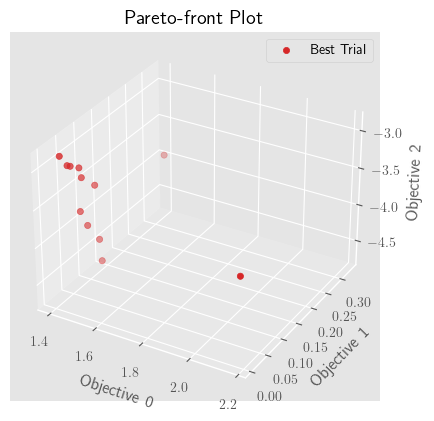

In [34]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
#plt.scatter(*attribs_focus.values(), color='green')

In [49]:
joblib.dump(opt_trial.study.trials, 
            data_base_dir /"trials.joblib", compress=4)

['/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/jupyter/sims_w_noise/for_paper/fwhm_peak_location_peak_intensity/trials.joblib']

In [48]:
data_base_dir = Path("/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/jupyter/sims_w_noise/for_paper/fwhm_peak_location_peak_intensity")

In [50]:
hist_dir = Path(data_base_dir)
hist_dir.exists()

True

In [61]:
trials_file = data_base_dir / "trials.joblib"

In [62]:
study = analysis.create_study_from_trials(trials_file, n_objectives=3)
n_steps = len(study.trials)

[I 2023-06-02 18:25:53,055] A new study created in memory with name: no-name-8584d07a-1045-477e-aed7-ae6a043f4a55


Assuming minimization for all objectives.


In [65]:
hists = analysis.load_histograms_from_files(n_steps, hist_dir, extension='gz')

In [66]:
nash_trial, nash_idx, n_doms = analysis.select_nash_equil_trial_from_pareto_front(study)

In [67]:
nash_trial

FrozenTrial(number=42, state=TrialState.COMPLETE, values=[1.4026326714960196, 0.04307496146069186, -3.07707745082532], datetime_start=datetime.datetime(2023, 6, 2, 15, 52, 50, 653896), datetime_complete=datetime.datetime(2023, 6, 2, 15, 53, 10, 421697), params={'hb_1': 20.0, 'hb_2': 4.0, 'hb_pitch': -0.0010999999999999998, 'hb_trans': 0.015200000000000005, 'vb_bender': -4.0, 'vb_pitch': 0.0019399999999999999, 'vb_trans': -0.0028999999999999963}, user_attrs={'sum_intensity_constraint': -1, 'dw': <aps.common.ml.data_structures.DictionaryWrapper object at 0x7fc29abd7910>, 'ws': 207075.64326753674}, system_attrs={'constraints': (-1,)}, intermediate_values={}, distributions={'hb_1': FloatDistribution(high=25.0, log=False, low=-25.0, step=None), 'hb_2': FloatDistribution(high=25.0, log=False, low=-25.0, step=None), 'hb_pitch': FloatDistribution(high=0.0019, log=False, low=-0.002, step=None), 'hb_trans': FloatDistribution(high=0.0299, log=False, low=-0.03, step=None), 'vb_bender': FloatDistri

Trial number 7
Trial values: peak_distance 7.473e-02 fwhm 1.403e+00 int -3.802e+00
Trial dw:
{'h_sigma': 0.4039823617586469, 'h_fwhm': 1.4026289062499964, 'h_centroid': -0.0004906262009008733, 'h_peak': -0.07472460937500003, 'v_sigma': 0.4787516911424077, 'v_fwhm': 0.01949999999999985, 'v_centroid': -2.581007624052889e-05, 'v_peak': -0.0008124999999999938, 'integral_intensity': 527779.7518112788, 'peak_intensity': 44.790065739930725, 'gaussian_fit': {}}
Actual fwhm 1.4027644487397237


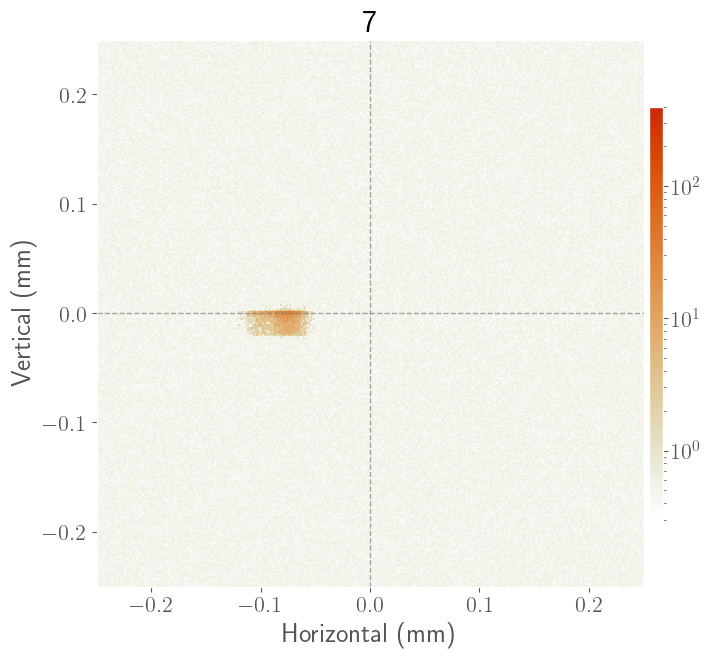

Trial number 11
Trial values: peak_distance 5.130e-02 fwhm 1.403e+00 int -3.115e+00
Trial dw:
{'h_sigma': 0.4041142373489603, 'h_fwhm': 1.4026289062499964, 'h_centroid': 1.9067442330045203e-05, 'h_peak': -0.003427734374999991, 'v_sigma': 0.4789063525919613, 'v_fwhm': 0.00649999999999995, 'v_centroid': 0.00036254541261385165, 'v_peak': -0.05118750000000005, 'integral_intensity': 527586.0713270709, 'peak_intensity': 22.523881525094982, 'gaussian_fit': {}}
Actual fwhm 1.4026439671734452


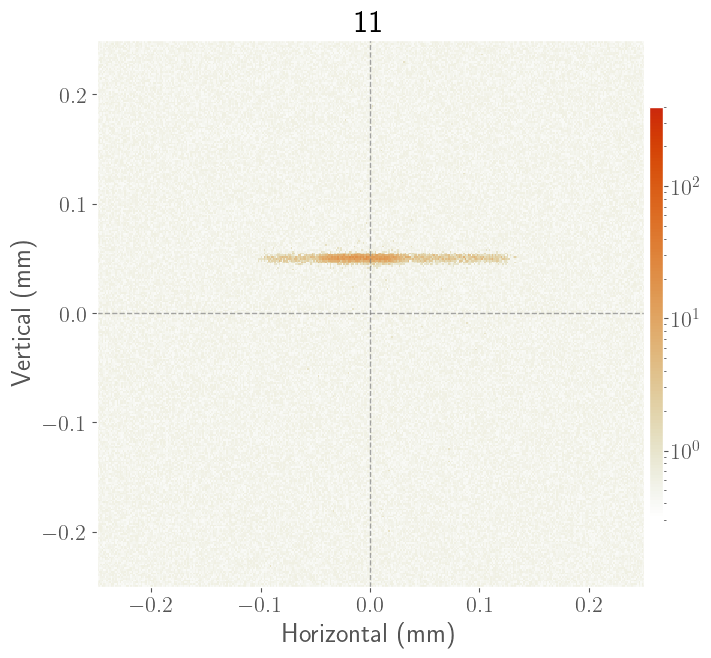

Trial number 12
Trial values: peak_distance 9.399e-02 fwhm 1.403e+00 int -4.065e+00
Trial dw:
{'h_sigma': 0.40414341190849673, 'h_fwhm': 1.4026289062499964, 'h_centroid': -0.00020948541994142422, 'h_peak': -0.06375585937500006, 'v_sigma': 0.47900008146293327, 'v_fwhm': 0.004874999999999963, 'v_centroid': -0.0004733116879122312, 'v_peak': 0.06906250000000003, 'integral_intensity': 527510.4817577208, 'peak_intensity': 58.2467864754871, 'gaussian_fit': {}}
Actual fwhm 1.4026373780393353


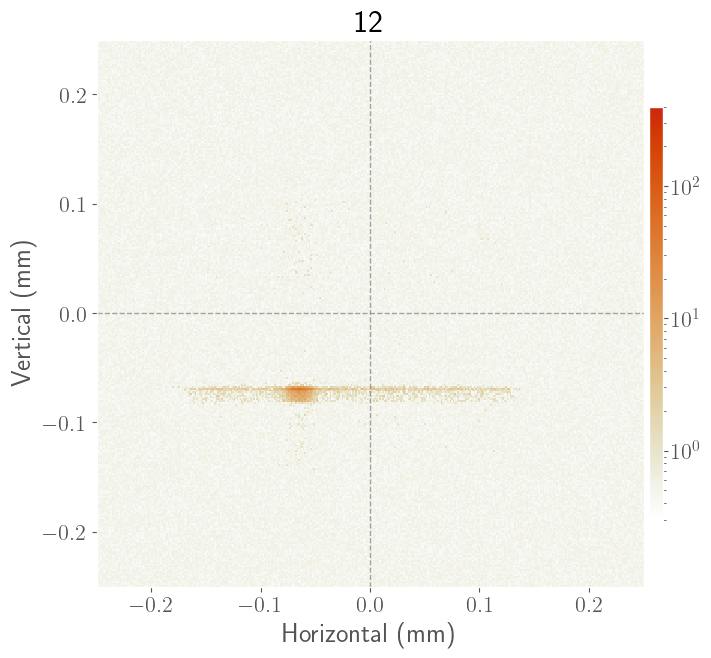

Trial number 19
Trial values: peak_distance 5.729e-03 fwhm 2.175e+00 int -3.658e+00
Trial dw:
{'h_sigma': 0.40397287830210354, 'h_fwhm': 1.4026289062499964, 'h_centroid': 8.90082536217085e-05, 'h_peak': 0.0006855468749999982, 'v_sigma': 0.4787785241226045, 'v_fwhm': 1.6623749999999873, 'v_centroid': -4.4836438700512904e-05, 'v_peak': -0.0056874999999999565, 'integral_intensity': 527703.8201965281, 'peak_intensity': 38.798319264535635, 'gaussian_fit': {}}
Actual fwhm 2.175053675032646


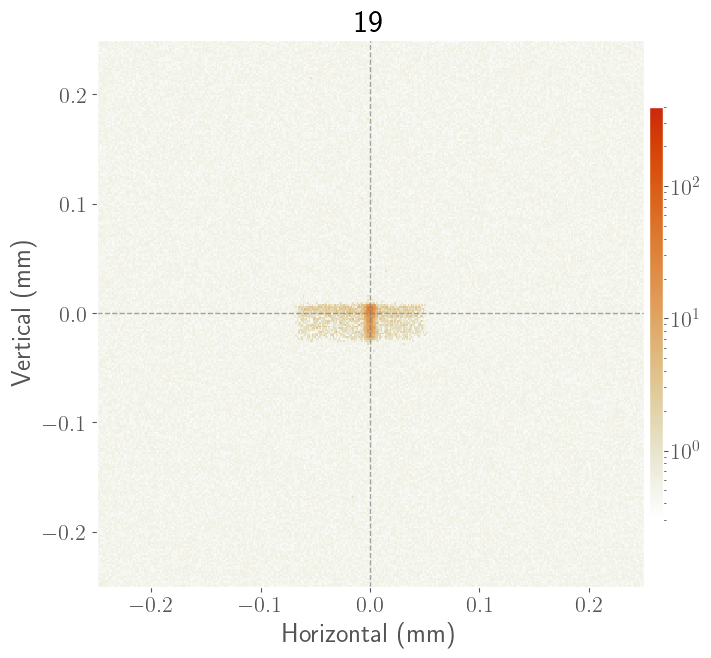

Trial number 31
Trial values: peak_distance 1.174e-01 fwhm 1.403e+00 int -3.605e+00
Trial dw:
{'h_sigma': 0.40413353114696565, 'h_fwhm': 1.4026289062499964, 'h_centroid': -0.0005739254076093658, 'h_peak': -0.11722851562500003, 'v_sigma': 0.4788708688153618, 'v_fwhm': 0.003249999999999975, 'v_centroid': 2.619764183336981e-06, 'v_peak': -0.0056874999999999565, 'integral_intensity': 527553.472849446, 'peak_intensity': 36.777452660512, 'gaussian_fit': {}}
Actual fwhm 1.4026326714960196


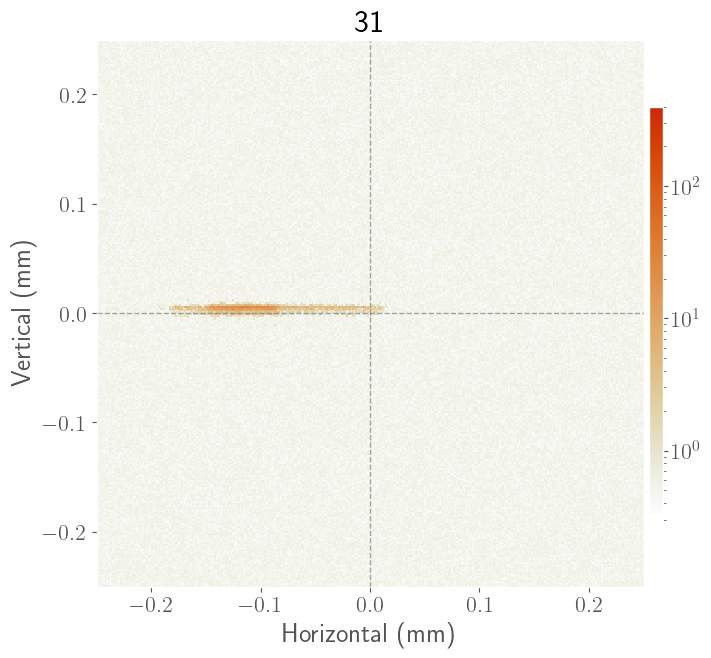

Trial number 32
Trial values: peak_distance 2.333e-02 fwhm 1.403e+00 int -2.886e+00
Trial dw:
{'h_sigma': 0.40414573195411085, 'h_fwhm': 1.4026289062499964, 'h_centroid': -2.044377648588447e-05, 'h_peak': 0.022623046875000052, 'v_sigma': 0.4789336835597722, 'v_fwhm': 0.004874999999999963, 'v_centroid': -5.4906868756116056e-05, 'v_peak': 0.0056874999999999565, 'integral_intensity': 527346.2952398768, 'peak_intensity': 17.913116586641603, 'gaussian_fit': {}}
Actual fwhm 1.4026373780393353


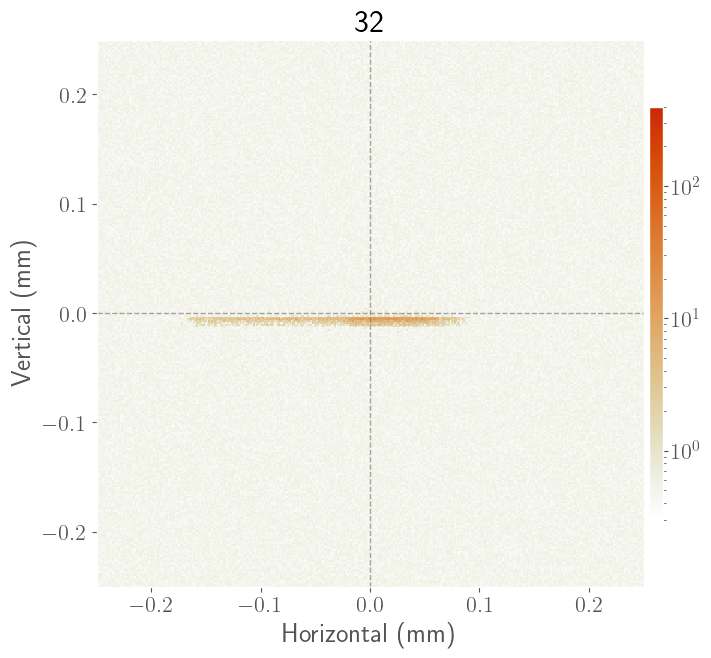

Trial number 34
Trial values: peak_distance 3.276e-01 fwhm 1.403e+00 int -3.944e+00
Trial dw:
{'h_sigma': 0.4048522184595499, 'h_fwhm': 1.4026289062499964, 'h_centroid': -0.002140052415040339, 'h_peak': -0.32700585937500004, 'v_sigma': 0.4788100044925161, 'v_fwhm': 0.003249999999999975, 'v_centroid': 0.00016810993763494153, 'v_peak': -0.020312499999999956, 'integral_intensity': 527834.1433340491, 'peak_intensity': 51.64127935227993, 'gaussian_fit': {}}
Actual fwhm 1.4026326714960196


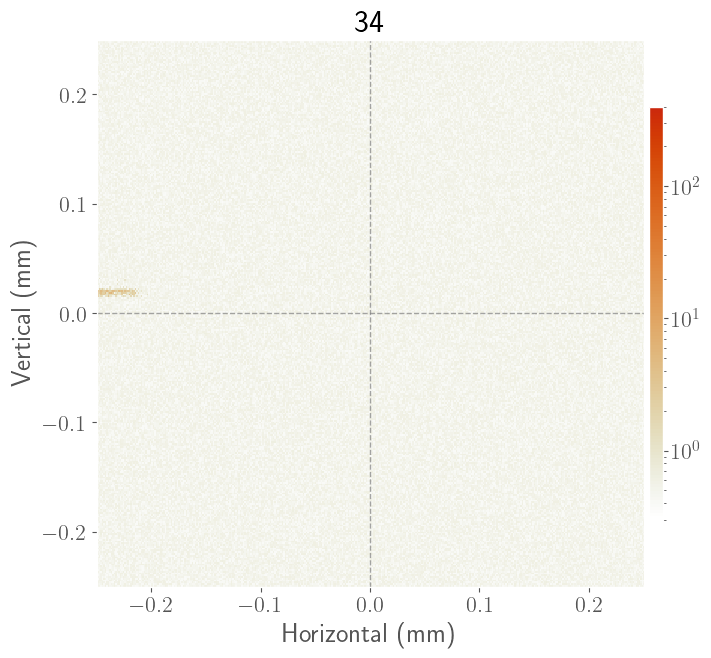

Trial number 42
Trial values: peak_distance 4.307e-02 fwhm 1.403e+00 int -3.077e+00
Trial dw:
{'h_sigma': 0.4039979514819218, 'h_fwhm': 1.4026289062499964, 'h_centroid': -0.00010940275378570896, 'h_peak': -0.03084960937500003, 'v_sigma': 0.47876052295745747, 'v_fwhm': 0.003249999999999975, 'v_centroid': -0.00017571384707790183, 'v_peak': 0.030062499999999992, 'integral_intensity': 527680.7080926246, 'peak_intensity': 21.69490522722676, 'gaussian_fit': {}}
Actual fwhm 1.4026326714960196


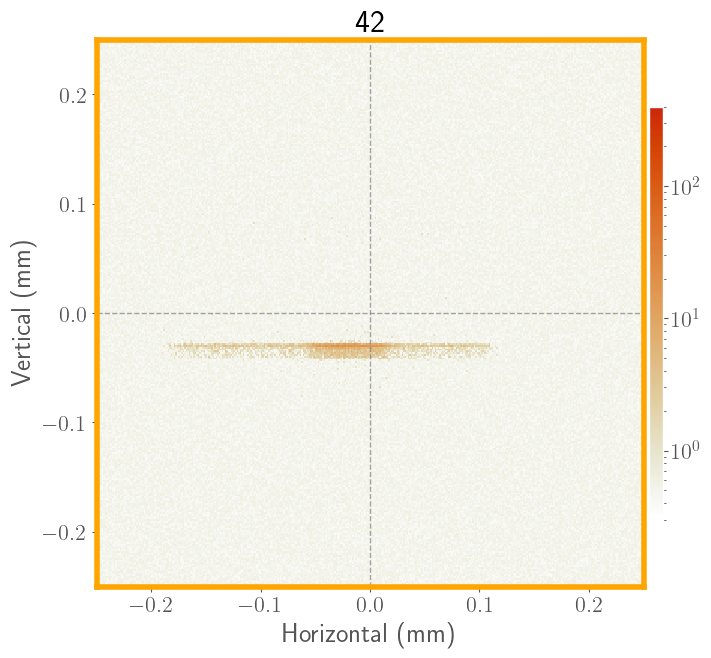

Trial number 50
Trial values: peak_distance 7.490e-02 fwhm 1.403e+00 int -3.220e+00
Trial dw:
{'h_sigma': 0.4040731232779218, 'h_fwhm': 1.4026289062499964, 'h_centroid': -0.00042360342938202455, 'h_peak': -0.06786914062500005, 'v_sigma': 0.4788996638388668, 'v_fwhm': 0.004874999999999963, 'v_centroid': 0.000256267261099008, 'v_peak': -0.03168749999999998, 'integral_intensity': 527564.5589132458, 'peak_intensity': 25.031840838333963, 'gaussian_fit': {}}
Actual fwhm 1.4026373780393353


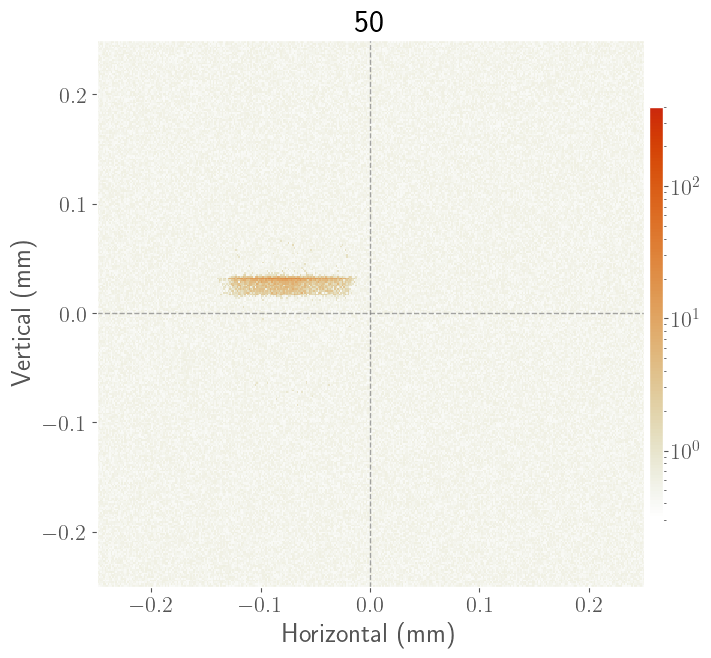

Trial number 54
Trial values: peak_distance 8.062e-02 fwhm 1.403e+00 int -3.370e+00
Trial dw:
{'h_sigma': 0.40399455218073815, 'h_fwhm': 1.4026289062499964, 'h_centroid': 0.000414741010833386, 'h_peak': 0.052787109374999974, 'v_sigma': 0.4788342492802155, 'v_fwhm': 0.011374999999999913, 'v_centroid': -0.0003226987177003815, 'v_peak': 0.06093749999999998, 'integral_intensity': 527571.3263111006, 'peak_intensity': 29.08250659530317, 'gaussian_fit': {}}
Actual fwhm 1.4026750298173347


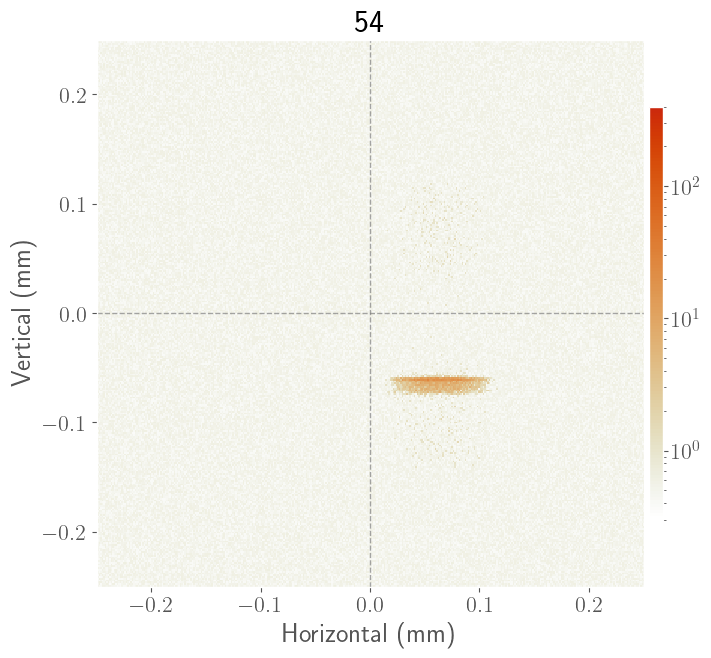

Trial number 80
Trial values: peak_distance 1.326e-01 fwhm 1.403e+00 int -4.707e+00
Trial dw:
{'h_sigma': 0.40420826206408594, 'h_fwhm': 1.4026289062499964, 'h_centroid': -0.0005451597444491862, 'h_peak': -0.11859960937500003, 'v_sigma': 0.4790103476901446, 'v_fwhm': 0.004874999999999963, 'v_centroid': -0.0003857542021623306, 'v_peak': 0.05931249999999999, 'integral_intensity': 527385.8044787317, 'peak_intensity': 110.68103334212, 'gaussian_fit': {}}
Actual fwhm 1.4026373780393353


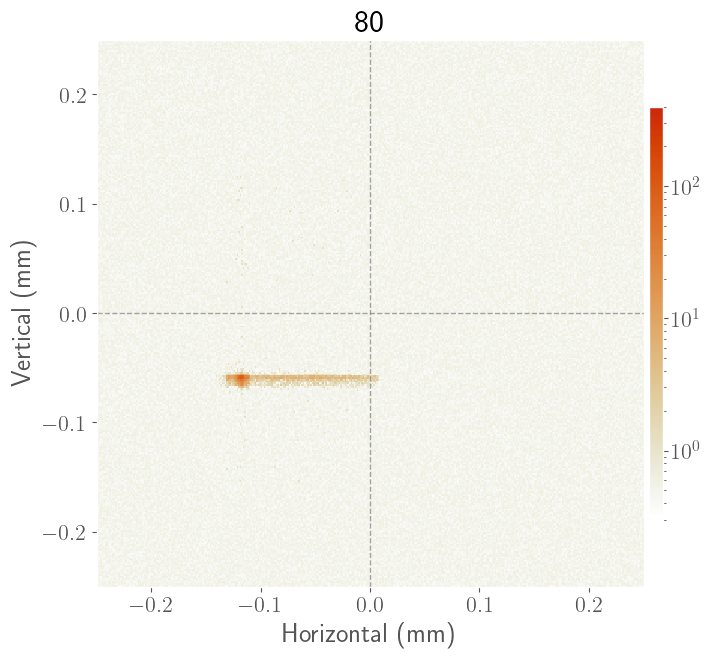

Trial number 85
Trial values: peak_distance 1.267e-01 fwhm 1.403e+00 int -4.383e+00
Trial dw:
{'h_sigma': 0.40420979199394336, 'h_fwhm': 1.4026289062499964, 'h_centroid': -0.0004878260705130921, 'h_peak': -0.11859960937500003, 'v_sigma': 0.47895652761996665, 'v_fwhm': 0.009749999999999925, 'v_centroid': -0.0003955533936256528, 'v_peak': 0.04468749999999999, 'integral_intensity': 527608.3227946485, 'peak_intensity': 80.10676436787153, 'gaussian_fit': {}}
Actual fwhm 1.402662793100345


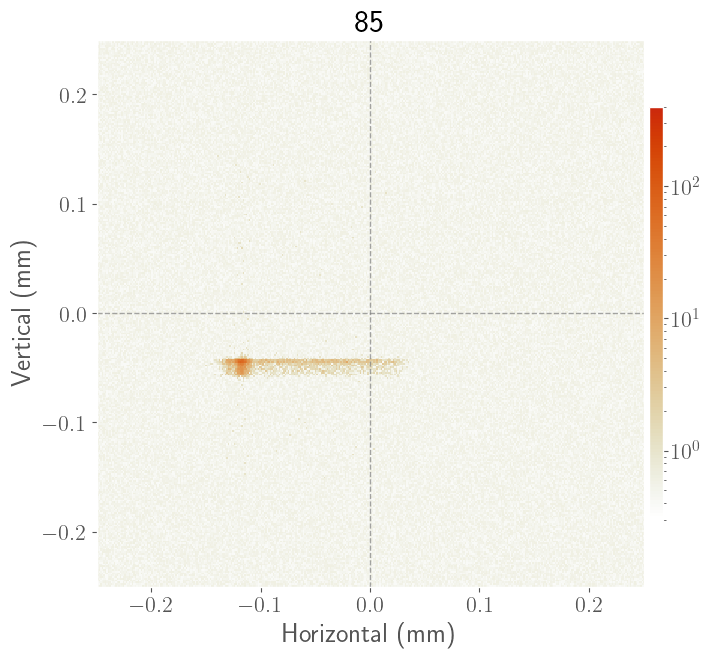

In [73]:
best_hists = []
for t in study.best_trials:
    print("Trial number", t.number)
    print(f"Trial values: peak_distance {t.values[1]:4.3e} fwhm {t.values[0]:4.3e} int {t.values[2]:4.3e}")
    print("Trial dw:")
    
    dw = dict(t.user_attrs["dw"]._DictionaryWrapper__dictionary)
    print(dw)
    print("Actual fwhm", opt_common._get_fwhm_from_dw(t.user_attrs["dw"]))
    hist = hists[t.number]
    plt.figure(figsize=[7,7], constrained_layout=True)
    plt.pcolormesh(hist.hh, hist.vv, hist.data_2D.T, cmap=m2, norm=mpl.colors.LogNorm(0.3, 4e2))
    plt.xlim(-0.25,0.25)
    plt.ylim(-0.25,0.25)
    plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
    plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
    plt.xlabel('Horizontal (mm)')
    plt.ylabel('Vertical (mm)')
    plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

    ax = plt.gca()
    ax.set_aspect('equal')
    if t.number == nash_trial.number:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(4)
            ax.spines[axis].set_color('orange')

    plt.title(t.number)
    plt.show()

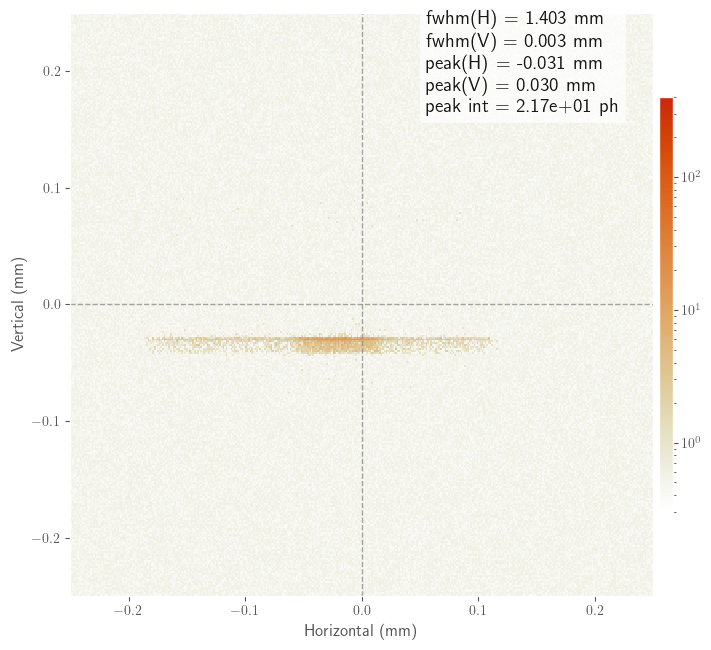

In [91]:

tnum = nash_trial.number
dw = dict(**study.trials[tnum].user_attrs["dw"]._DictionaryWrapper__dictionary)
hist = hists[tnum]
plt.figure(figsize=[7,7], constrained_layout=True)
plt.pcolormesh(hist.hh, hist.vv, hist.data_2D.T, cmap=m2, norm=mpl.colors.LogNorm(0.3, 4e2))
plt.xlim(-0.25,0.25)
plt.ylim(-0.25,0.25)
plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.xlabel('Horizontal (mm)')
plt.ylabel('Vertical (mm)')
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

ax = plt.gca()
ax.set_aspect('equal')

text = (f"{'fwhm(H)':<6} = {dw['h_fwhm']: 4.3f} mm\n"
             f"{'fwhm(V)':<9} = {dw['v_fwhm']: 4.3f} mm\n"
             f"{'peak(H)':<9} = {dw['h_peak']: 4.3f} mm\n"
             f"{'peak(V)':<9} = {dw['v_peak']: 4.3f} mm\n"
             f"{'peak int':<9} = {dw['peak_intensity']: 3.2e} ph")
ax.text(0.055, 0.165, text, color='black', alpha=0.9, fontsize=14,
        bbox=dict(facecolor='white', edgecolor='white', alpha=0.7))
plt.show()

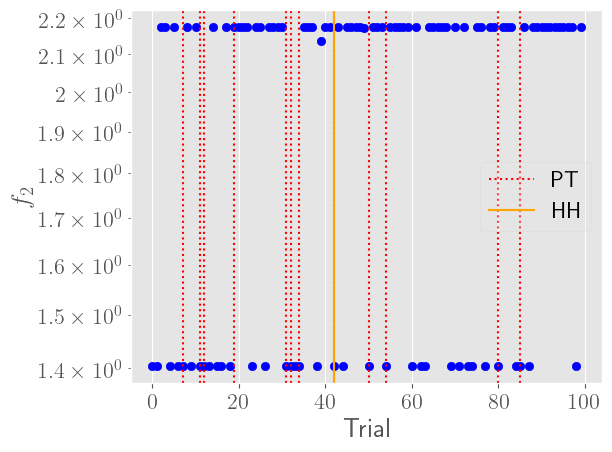

In [75]:
# Plotting the optimization histories
#optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
#plt.scatter(study.trials.values
plt.figure()
x = [t.number for t in study.trials]
y = [t.values[0] for t in study.trials]
plt.scatter(x,y, color='blue')
plt.xlabel('Trial')
plt.ylabel('$f_2$')
plt.yscale('log')
for t in study.best_trials[:-1]:
    plt.axvline(t.number, color='red', ls=':')
plt.axvline(study.best_trials[-1].number, color='red', ls=':', label='PT')
plt.axvline(nash_trial.number, color='orange', label='HH')
plt.legend(loc="best", framealpha=0.3)
plt.tight_layout()
plt.show()

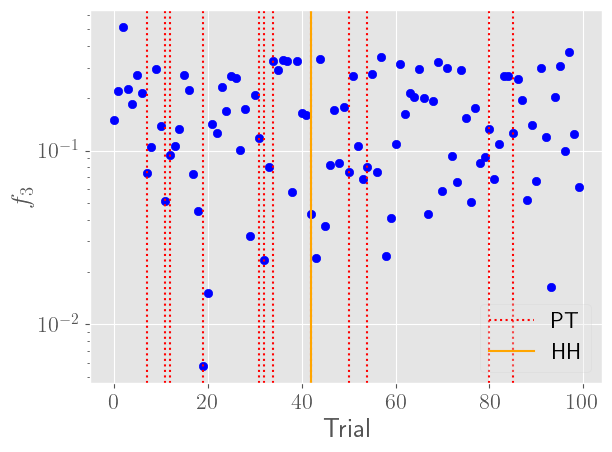

In [76]:
# Plotting the optimization histories
#optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
#plt.scatter(study.trials.values
plt.figure()
x = [t.number for t in study.trials]
y = [t.values[1] for t in study.trials]
plt.scatter(x,y, color='blue')
plt.xlabel('Trial')
plt.ylabel('$f_3$')
plt.yscale('log')
for t in study.best_trials[:-1]:
    plt.axvline(t.number, color='red', ls=':')
plt.axvline(study.best_trials[-1].number, color='red', ls=':', label='PT')
plt.axvline(nash_trial.number, color='orange', label='HH')
plt.legend(loc="best", framealpha=0.3)
plt.tight_layout()
plt.show()

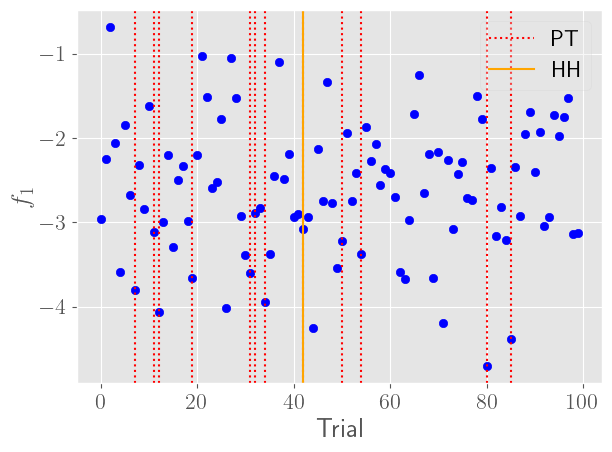

In [77]:
# Plotting the optimization histories
#optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
#plt.scatter(study.trials.values
plt.figure()
x = [t.number for t in study.trials]
y = [t.values[2] for t in study.trials]
plt.scatter(x,y, color='blue')
plt.xlabel('Trial')
plt.ylabel('$f_1$')
#plt.yscale('symlog')
for t in study.best_trials[:-1]:
    plt.axvline(t.number, color='red', ls=':')
plt.axvline(study.best_trials[-1].number, color='red', ls=':', label='PT')
plt.axvline(nash_trial.number, color='orange', label='HH')
plt.legend(loc="best", framealpha=0.3)
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_14308/4276538448.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(study, targets=lambda t: [t.values[0], t.values[1]],


<AxesSubplot:title={'center':'Pareto-front Plot'}, xlabel='fwhm', ylabel='peak_location'>

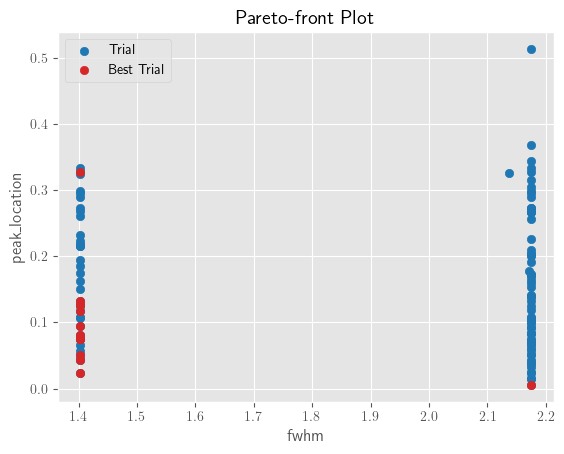

In [86]:
optuna.visualization.matplotlib.plot_pareto_front(study, targets=lambda t: [t.values[0], t.values[1]], 
                                                  target_names=['fwhm', 'peak_location'])

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_14308/1878567083.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(study, targets=lambda t: [t.values[1], t.values[2]],


<AxesSubplot:title={'center':'Pareto-front Plot'}, xlabel='peak_location', ylabel='peak_intensity'>

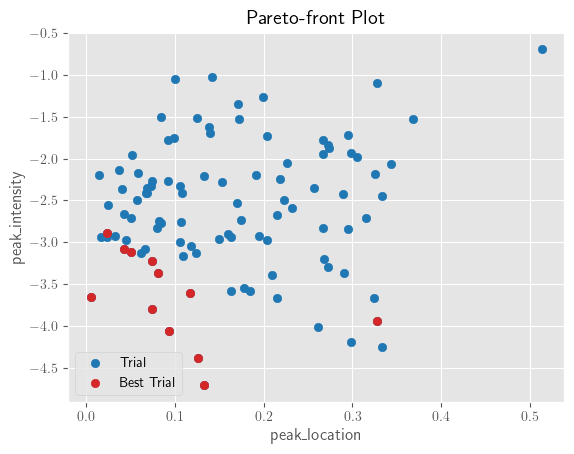

In [87]:
optuna.visualization.matplotlib.plot_pareto_front(study, targets=lambda t: [t.values[1], t.values[2]],
                                                 target_names=['peak_location', 'peak_intensity'])

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_14308/1459714951.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(study, targets=lambda t: [t.values[0], t.values[2]],


<AxesSubplot:title={'center':'Pareto-front Plot'}, xlabel='fwhm', ylabel='peak_int'>

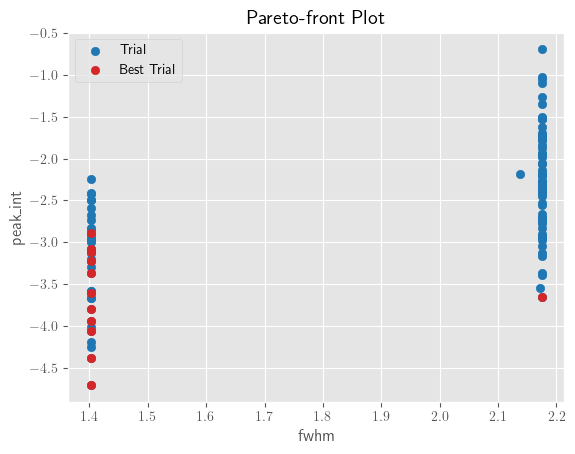

In [88]:
optuna.visualization.matplotlib.plot_pareto_front(study, targets=lambda t: [t.values[0], t.values[2]],
                                                 target_names=['fwhm', 'peak_int'])

### Reanalyzing by calculating over noise


In [92]:
cp = opt_common.CalculationParameters(
    calculate_over_noise=True,
    noise_threshold=1.5,
)

In [100]:
new_hists = []
new_dws = []
for h in hists:
    h1, dw = analysis.recalculate_info(cp, h, crop=0)
    new_hists.append(h1)
    new_dws.append(dw)

In [101]:
# peak_location, fwhm, nlpi

test_val_fns = [
    lambda t: opt_common._get_fwhm_from_dw(new_dws[t.number]),
    lambda t: opt_common._get_peak_distance_from_dw(new_dws[t.number]),
    lambda t: -np.log(opt_common._get_peak_intensity_from_dw(new_dws[t.number])),    
]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, [1, 1, 1], values_fns=test_val_fns)
domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1, 1, 1], test_val_fns)
print(np.argmax(domins), len(test_pareto))

19 5


In [102]:
nash_trial = study.trials[np.argmax(domins)]

Trial number 7
Trial values: peak_distance 7.473e-02 fwhm 1.926e-02 int -3.802e+00
Trial dw:
{'h_sigma': 0.012301280754478734, 'h_fwhm': 0.01919531249999995, 'h_centroid': -0.07994525231668881, 'h_peak': -0.07472460937500003, 'v_sigma': 0.006425631825389249, 'v_fwhm': 0.0016249999999999876, 'v_centroid': -0.005744544107987914, 'v_peak': -0.0008124999999999938, 'integral_intensity': 1.1759077185131057, 'peak_intensity': 44.790065739930725, 'gaussian_fit': {}}


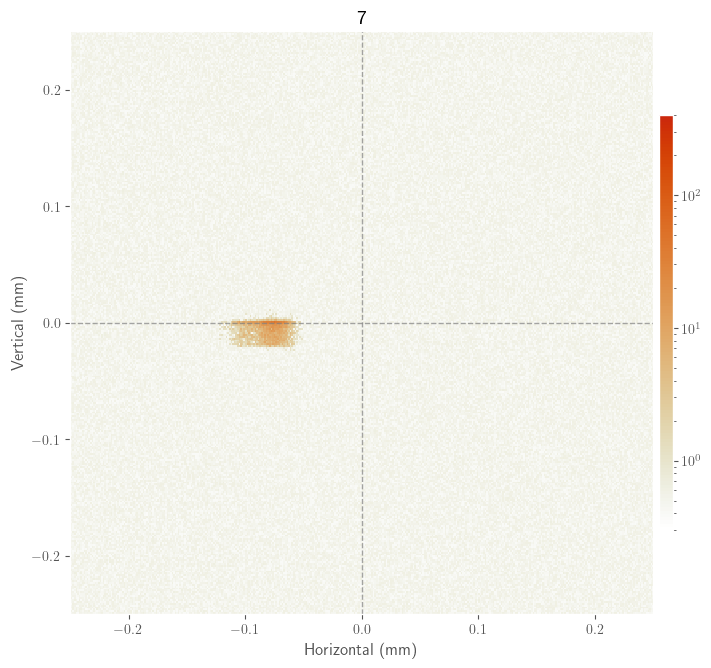

Trial number 12
Trial values: peak_distance 9.399e-02 fwhm 1.508e-02 int -4.065e+00
Trial dw:
{'h_sigma': 0.05737441062577657, 'h_fwhm': 0.015082031249999961, 'h_centroid': -0.045405142411743586, 'h_peak': -0.06375585937500006, 'v_sigma': 0.020568990630242204, 'v_fwhm': 0.0, 'v_centroid': -0.06944118839774203, 'v_peak': 0.06906250000000003, 'integral_intensity': 1.1753077774709255, 'peak_intensity': 58.2467864754871, 'gaussian_fit': {}}


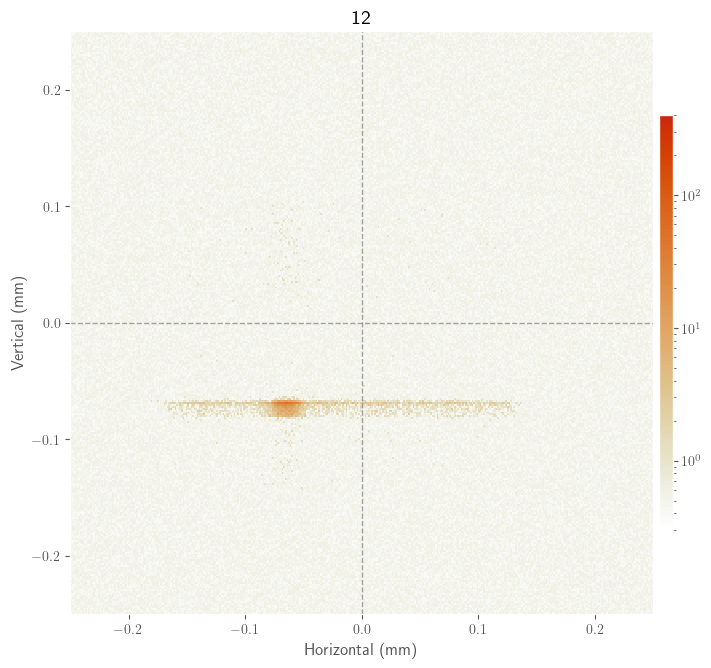

Trial number 19
Trial values: peak_distance 5.729e-03 fwhm 1.192e-02 int -3.658e+00
Trial dw:
{'h_sigma': 0.021997992082294304, 'h_fwhm': 0.006855468749999982, 'h_centroid': -0.004033670032052219, 'h_peak': 0.0006855468749999982, 'v_sigma': 0.010590906443687034, 'v_fwhm': 0.009749999999999925, 'v_centroid': -0.004471853798781742, 'v_peak': -0.0056874999999999565, 'integral_intensity': 1.175738540799186, 'peak_intensity': 38.798319264535635, 'gaussian_fit': {}}


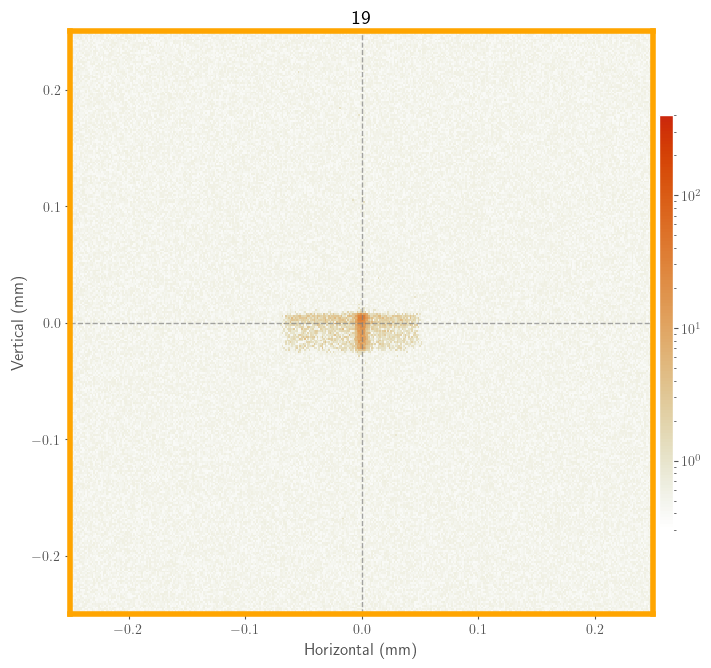

Trial number 80
Trial values: peak_distance 1.326e-01 fwhm 4.423e-03 int -4.707e+00
Trial dw:
{'h_sigma': 0.03602746801655801, 'h_fwhm': 0.004113281249999989, 'h_centroid': -0.09486871245881748, 'h_peak': -0.11859960937500003, 'v_sigma': 0.013330575107248981, 'v_fwhm': 0.0016249999999999876, 'v_centroid': -0.05920354644205292, 'v_peak': 0.05931249999999999, 'integral_intensity': 1.1750299930841934, 'peak_intensity': 110.68103334212, 'gaussian_fit': {}}


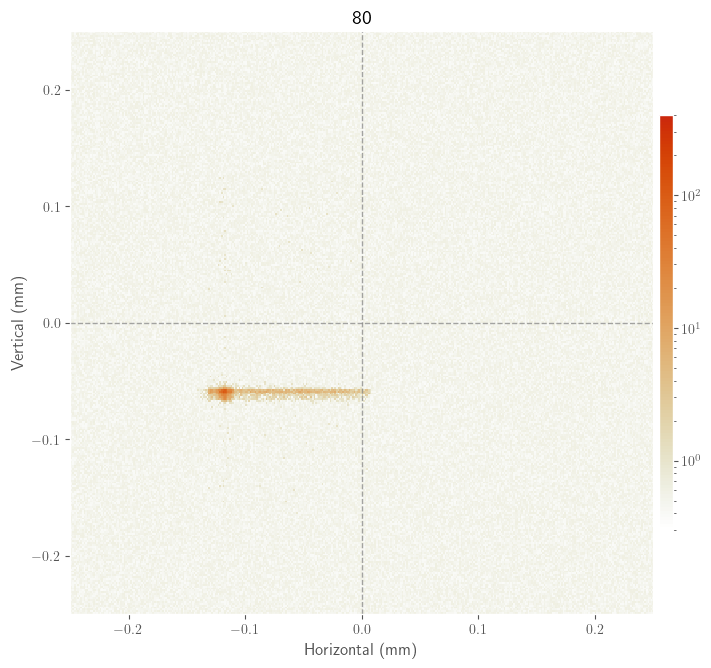

Trial number 85
Trial values: peak_distance 1.267e-01 fwhm 7.045e-03 int -4.383e+00
Trial dw:
{'h_sigma': 0.04143548188407292, 'h_fwhm': 0.006855468749999982, 'h_centroid': -0.09251122749179574, 'h_peak': -0.11859960937500003, 'v_sigma': 0.012800710153281722, 'v_fwhm': 0.0016249999999999876, 'v_centroid': -0.0462421436970164, 'v_peak': 0.04468749999999999, 'integral_intensity': 1.1755257699765411, 'peak_intensity': 80.10676436787153, 'gaussian_fit': {}}


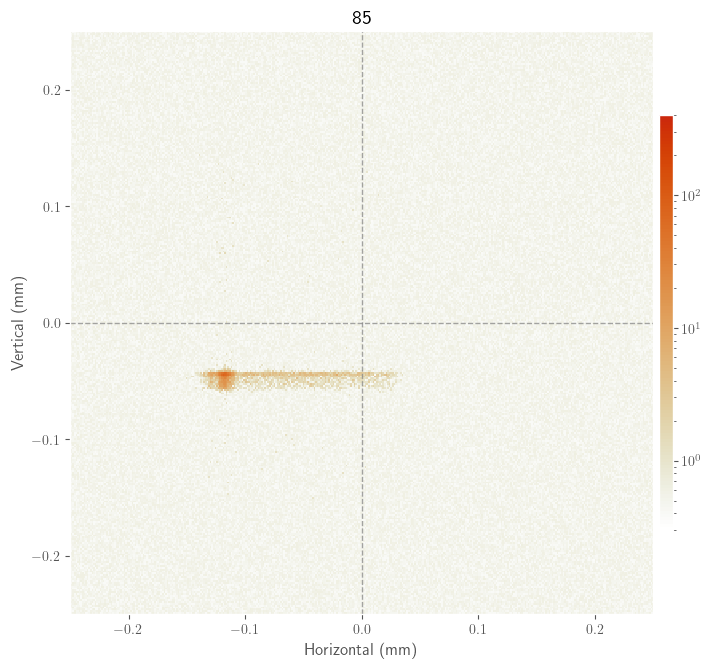

In [103]:
best_hists = []
for t in test_pareto:
    tnum = t.number
    tvals = test_values[tnum]
    print("Trial number", t.number)
    print(f"Trial values: peak_distance {tvals[1]:4.3e} fwhm {tvals[0]:4.3e} int {tvals[2]:4.3e}")
    print("Trial dw:")
    
    dw = dict(new_dws[tnum]._DictionaryWrapper__dictionary)
    print(dw)
    hist = new_hists[tnum]
    plt.figure(figsize=[7,7], constrained_layout=True)
    plt.pcolormesh(hist.hh, hist.vv, hist.data_2D.T, cmap=m2, norm=mpl.colors.LogNorm(0.3, 4e2))
    plt.xlim(-0.25,0.25)
    plt.ylim(-0.25,0.25)
    plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
    plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
    plt.xlabel('Horizontal (mm)')
    plt.ylabel('Vertical (mm)')
    plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

    ax = plt.gca()
    ax.set_aspect('equal')
    if t.number == nash_trial.number:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(4)
            ax.spines[axis].set_color('orange')

    plt.title(t.number)
    plt.show()